<a href="https://colab.research.google.com/github/khickey25/nlp_shap_notebooks/blob/master/nlp_shap_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP SHAP Analysis Notebook 2

## Author: Kevin Hickey

### This Notebook is follows the outline in 'nlp_shap' notebook, but with one significant change in process.

We remove words before text is formatted in a one-hot encoded format. As such, the notebook follows the outline explained below. 

1. Display baseline classifier shap values (from 'nlp_shap' notebook, where shap values are saved to google drive) figures for comparison purposes in steps below
2. Read in preformatted text from google drive. 
3. Drop/remove predefined words in the text corpus created from previous step. Thus, words are removed before OHE the text.
4. Tokenize text into OHE format of predefined size vocabulary. 
5. Train text classifier, same architecture as 'nlp_shap' notebook, and print performance metrics.
6. Calculate predefined amount of shap values and display figures. 

In [206]:
#housekeeping steps
from google.colab import drive
drive.mount('/content/drive')

!pip install shap
!pip install lime

import pandas as pd
%tensorflow_version 1.13.1
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import matplotlib.pyplot as plt
import shap
import numpy
import sklearn.metrics as skm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tqdm import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [207]:
#read in presaved and preformatted text and baseline model shap values

text_train_path = "/content/drive/My Drive/test_data/text_train.csv"
text_test_path = "/content/drive/My Drive/test_data/text_test.csv"
y_train_path = "/content/drive/My Drive/test_data/y_train.csv"
y_test_path = "/content/drive/My Drive/test_data/y_test.csv"

text_train = pd.read_csv(text_train_path, names=['text'])
text_test = pd.read_csv(text_test_path, names=['text'])
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

baseline_model_shap_vals = numpy.load("/content/drive/My Drive/test_data/shap_vals.npy")

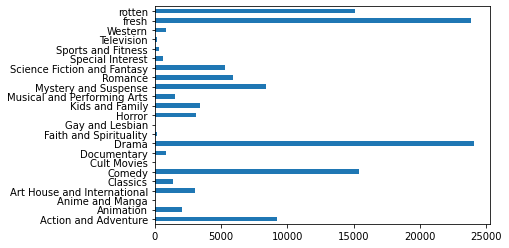

In [208]:
pd.concat([text_train, y_train], axis=1).iloc[:, 1:].sum(axis = 0, skipna = True).plot(kind='barh')

In [202]:
#define set of helper functions

class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

def read_data():
  """Load presaved and preformated text from google drive.
  Returns:
    text_train {pandas.DataFrame}: Train set of text reviews.
    text_test {pandas.DataFrame}: Test set of text reviews.
    y_train {pandas.DataFrame}: Ground truth labels for text_train.
    y_test {pandas.DataFrame}: Ground truth labels for text_test.
    """
  text_train_path = "/content/drive/My Drive/test_data/text_train.csv"
  text_test_path = "/content/drive/My Drive/test_data/text_test.csv"
  y_train_path = "/content/drive/My Drive/test_data/y_train.csv"
  y_test_path = "/content/drive/My Drive/test_data/y_test.csv"

  text_train = pd.read_csv(text_train_path, names=['text'])
  text_test = pd.read_csv(text_test_path, names=['text'])
  y_train = pd.read_csv(y_train_path)
  y_test = pd.read_csv(y_test_path)

  return text_train, text_test, y_train, y_test




def preprocess_text(vocab_size, x_train_text, x_test_text, text_processor):
  """Instatiates an instance of TextPreProcessor class and transforms training 
  and testing text splits.
  Arguments:
    vocab_size {int}: Size of resulting tokenized train and test splits.
    x_train_text {pandas.DataFrame or pandas.Series}: Training set of text to tokenize.
    x_test_text {pandas.DataFrmae}: Testing set of text to tokenize.
    text_processor {class '__main__.TextPreprocessor'}: Tokenizer to tokenize train/test text splits.
  Returns:
    X_train {numpy.ndarray}: Tokenized/OHE text training split.
    X_test {numpy.ndarray}: Tokenized/OHE text test split.
    """
  #if removing words from text_train, it will be a pd.Series
  if isinstance(x_train_text, pd.Series):
    text_processor.create_tokenizer(x_train_text.iloc[:])
    X_train = text_processor.transform_text(x_train_text.iloc[:])
  else:
    #train_post = merged['Body'].values[: train_size]
    #test_post = merged['Body'].values[train_size: ]
    text_processor.create_tokenizer(x_train_text.iloc[:, -1])
    X_train = text_processor.transform_text(x_train_text.iloc[:, -1])
  
  X_test = text_processor.transform_text(x_test_text.iloc[:, -1])
  return X_train, X_test
  
def word_lookup_creation(processor):
  """Creates a mapping between original text and resulting words in text training split.
  Returns:
    words {dict}: Dictionary where keys are particular word in vocabulary,
                  and value is the index of said word (E.g. {'person': 1, 'gpe': 2 }).
    word_lookup {list}: List of words ordered by their index position of length vocabulary size 
                        (E.g. ['person', 'gpe',...])
                        """ 
                
  words = processor._tokenizer.word_index
  word_lookup = list()
  for i in words.keys():
      word_lookup.append(i)
  word_lookup = [''] + word_lookup
  return words, word_lookup
  
def create_model(input_shape, num_tags):
  """Instantiates a text classifier and returns it.
  Arguments:
    input_shape {int}: Size of input array, typically the vocabulary size.
    num_tags {int}: ???
  Returns:
    model {tf.keras.Sequential}: Instantiated model to be trained.  
    """
  tf.random.set_random_seed(2020)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_shape = (input_shape,), activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  return model

def train_and_score(model, train_data_X, train_data_y, test_data_X, test_data_y, 
                    n_epochs, batch_size):
  """Train text classifier on particular set of text and print evaluation metrics.
  Arguments:
    model {tf.keras.Sequential}: Instantiated model to be trained.
    train_data_X {numpy.ndarray}: Training text data.
    train_data_y {numpy.ndarray}: Training text labels.
    test_data_X {numpy.ndarray}: Testing text data.
    test_data_y {numpy.ndarray}: Testing text labels.
    n_epochs {int}: Number of epochs to train through.
    batch_size {int}: Batch size to train on.
    """
  model.fit(train_data_X, train_data_y, epochs=n_epochs, batch_size=batch_size, 
            validation_split=0.1)
  print('Eval loss/accuracy:{}'.format(model.evaluate(test_data_X, test_data_y,
                                                      batch_size = batch_size)))

  return model




def shap_vals_calculation(n_examples:int, n_explanations:int, 
                          x_train:numpy.ndarray, x_test:numpy.ndarray,
                          model:tf.python.keras.engine.sequential.Sequential):
  """Calculates shap values of corresponing text classifier.
  Arguments:
    n_examples {int}: Number of examples to integrate over.
    n_eplanations {int}: Number of explanations to create. 
    x_train {numpy.ndarray}: Training set.
    x_test {numpy.ndarray}: Testing set to create shap value explantions for.
    model {tf.keras.Sequential}: Trained model to evaluate.
  Returns:
    shap_vals {tuple}: tuple of shap values of shape:
                       ((n_explantions, vocabulary size) x # of classes)
    """
  attrib_data = x_train[:n_examples]
  explainer = shap.DeepExplainer(model, attrib_data)
  shap_vals = explainer.shap_values(x_test[:n_explanations])
  return shap_vals

def display_shap_figures(shap_values, x_test, word_lookup_reference):
  """Displays shap global summary plot and summary plot for each individual class/genre.
  Arguments:
    shap_values {list}: List of calculated shap values.
    x_test {numpy.ndarray}: Testing split to display explanations about.
    word_lookup_reference {list}: list of words in vocabulary ordered by index position 
                                  to display on figures.
                                  """

  shap.summary_plot(shap_values, feature_names=word_lookup_reference, 
                    class_names=y_train.columns)

  for i in range(len(shap_values)):
    print(y_test.columns[i])
    shap.summary_plot(shap_values[i], x_test[:shap_values[0].shape[0]],
                      feature_names=word_lookup_reference, 
                      class_names=y_train.columns)






  

## Baseline Model Shap Figures

Due to computation complexity, a baseline model was trained (in 'nlp_shap' notebook) and subsequent shap values were calculated for all features. This allows for a fuller explanation of words for comparison puroses.

[INFO] Processing Text...

[INFO] Displaying Figures...


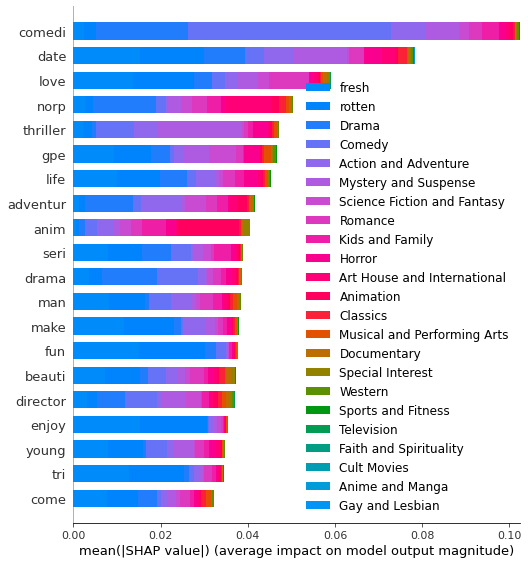

Action and Adventure


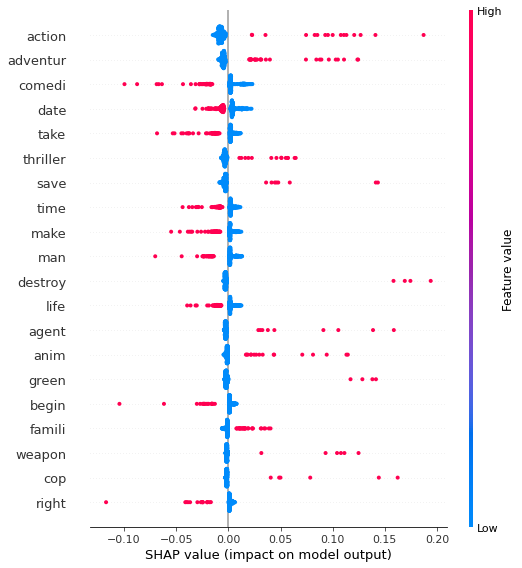

Animation


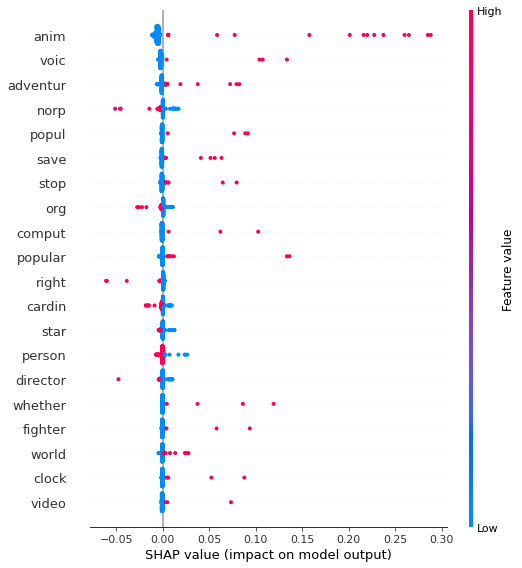

Anime and Manga


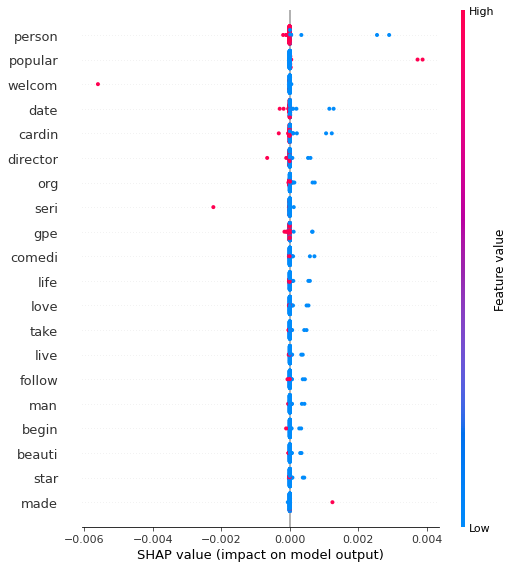

Art House and International


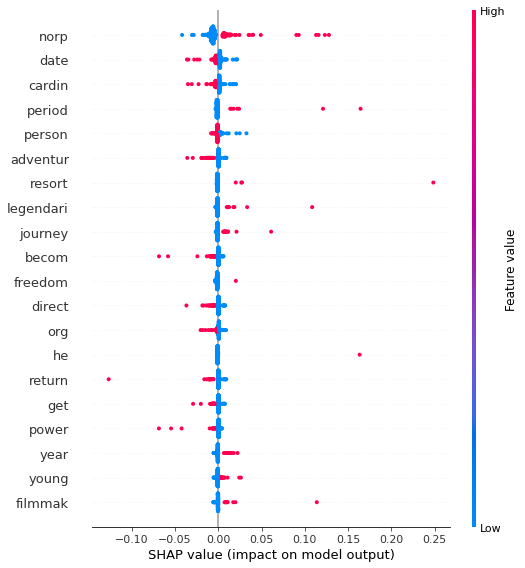

Classics


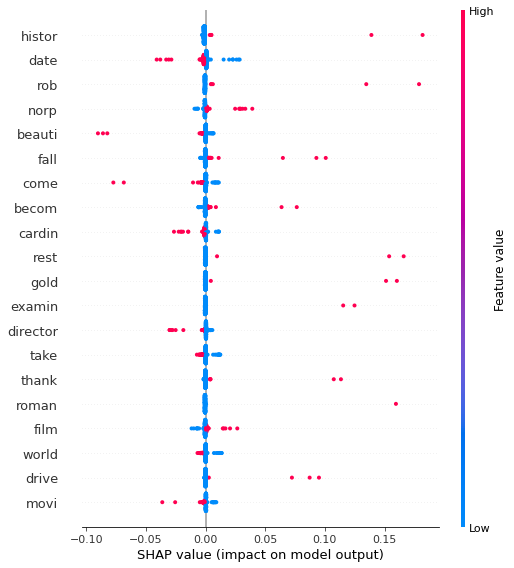

Comedy


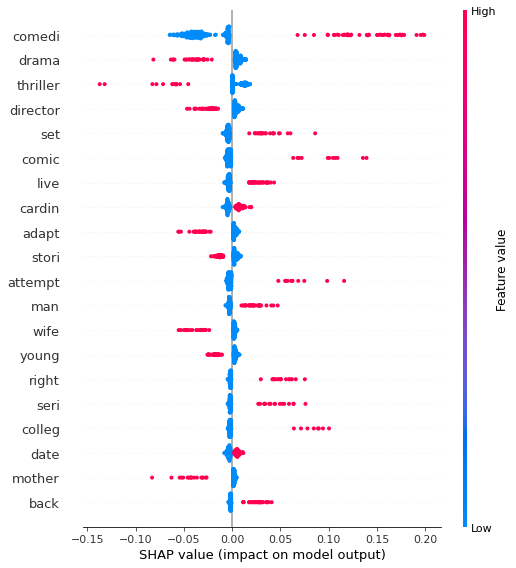

Cult Movies


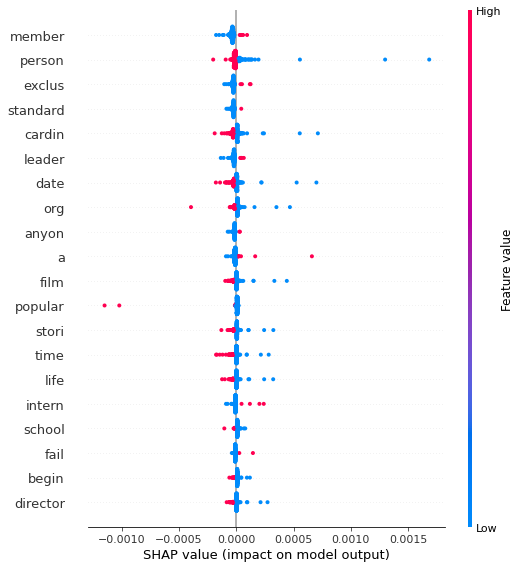

Documentary


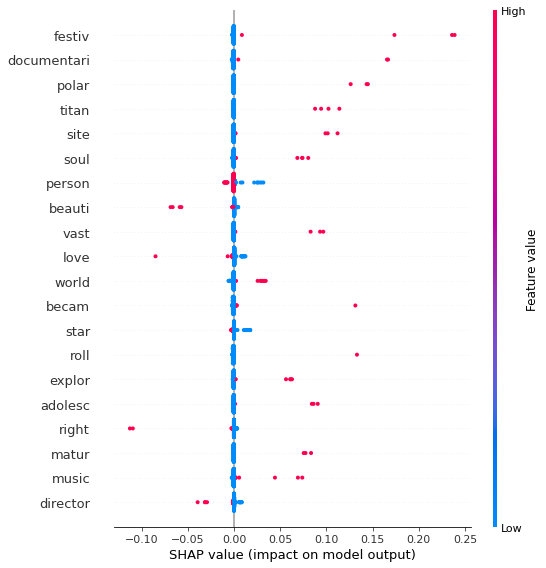

Drama


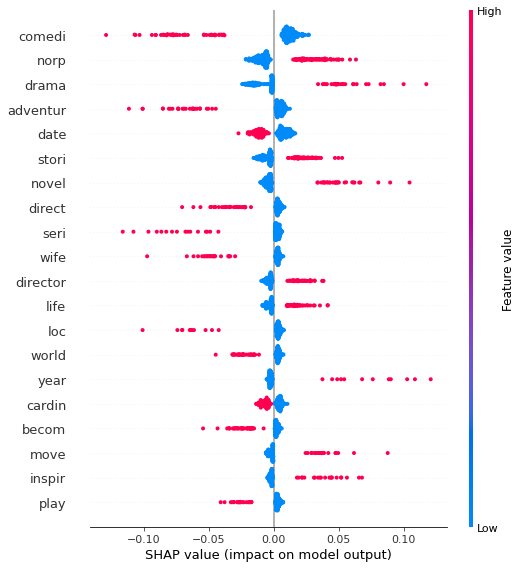

Faith and Spirituality


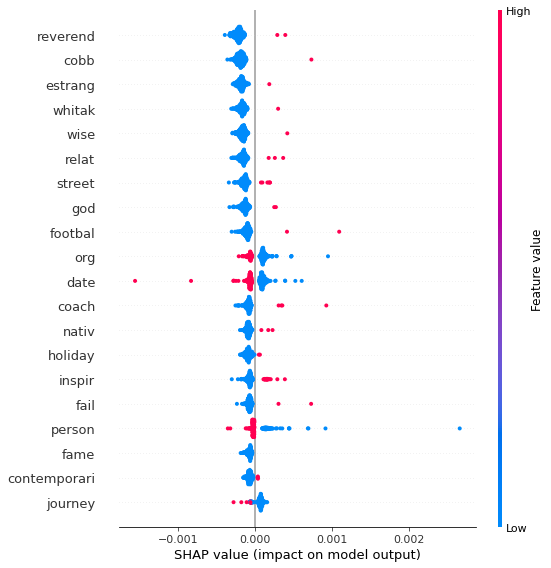

Gay and Lesbian


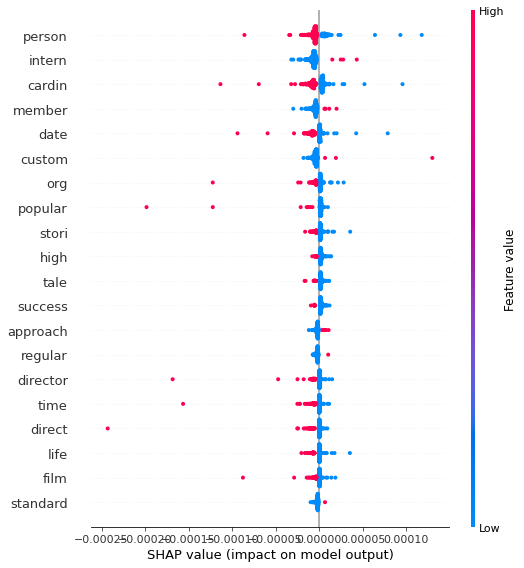

Horror


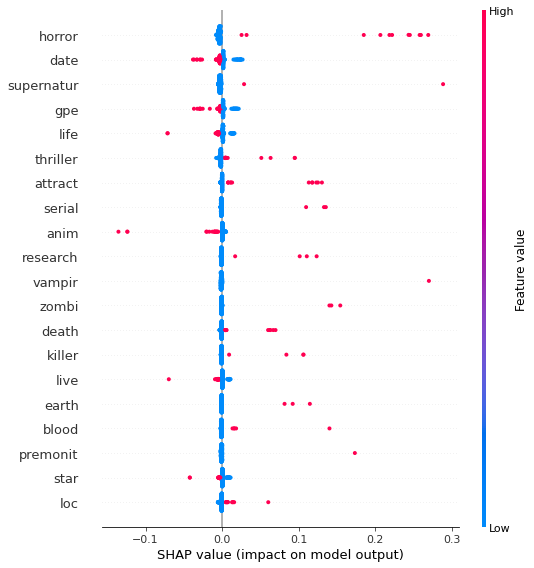

Kids and Family


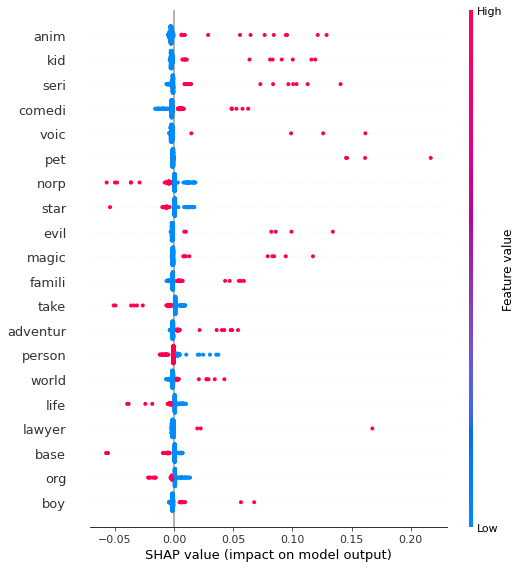

Musical and Performing Arts


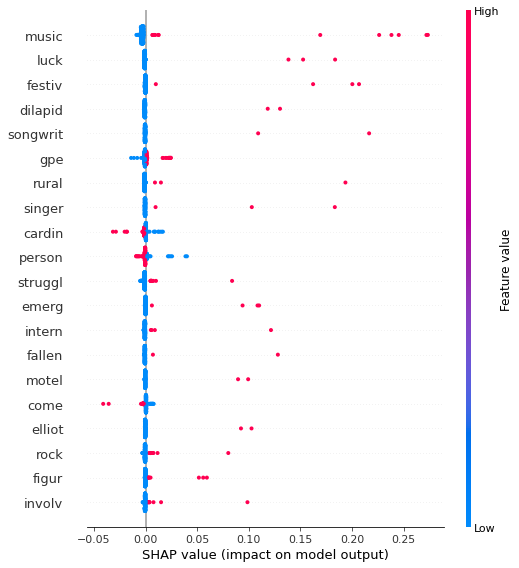

Mystery and Suspense


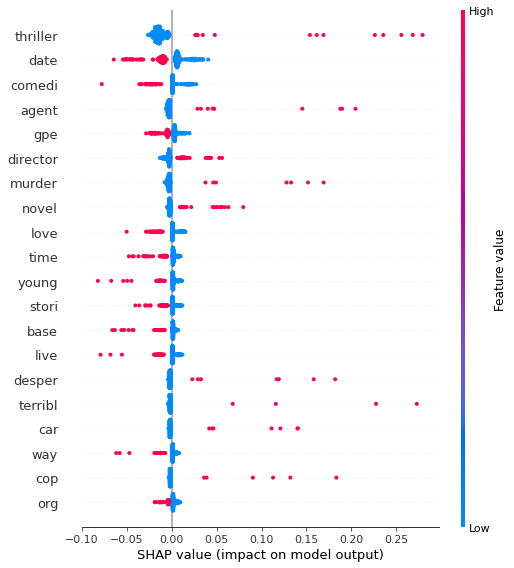

Romance


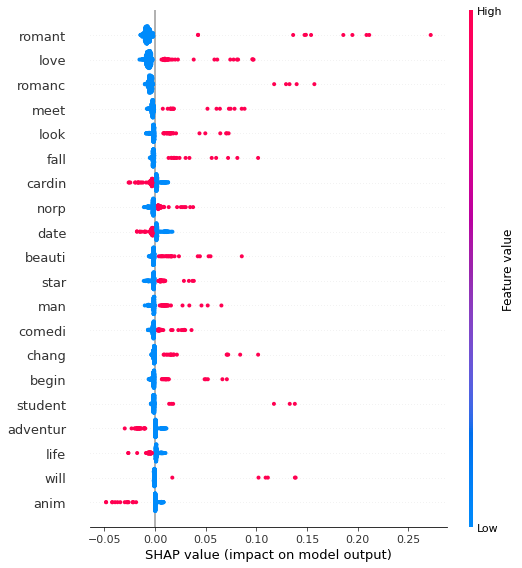

Science Fiction and Fantasy


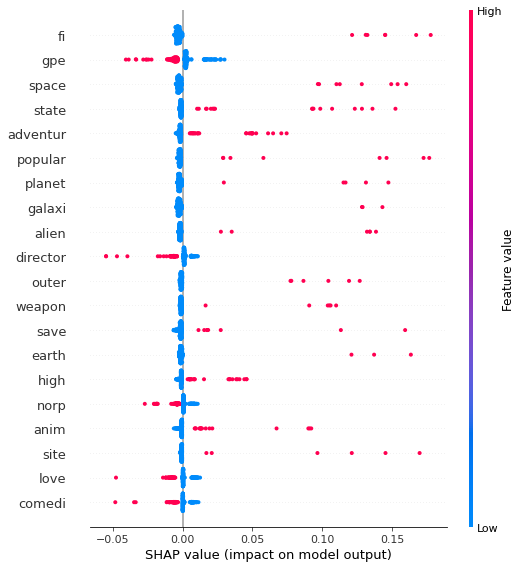

Special Interest


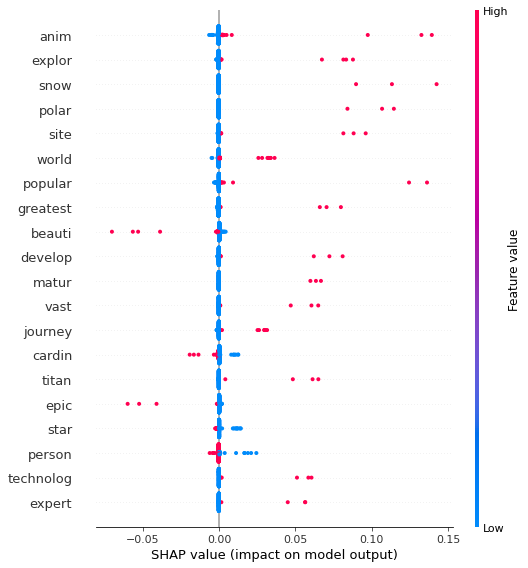

Sports and Fitness


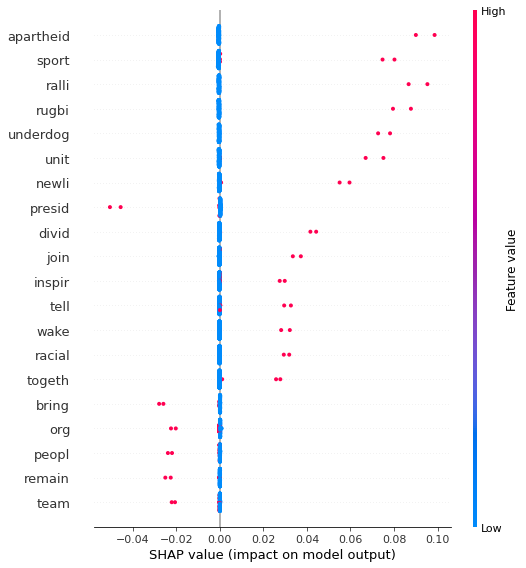

Television


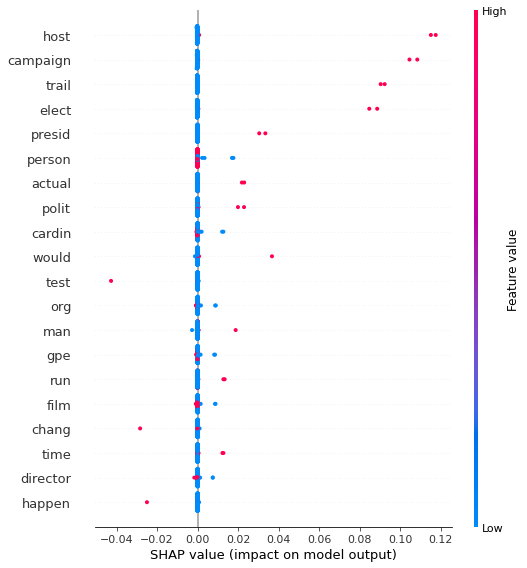

Western


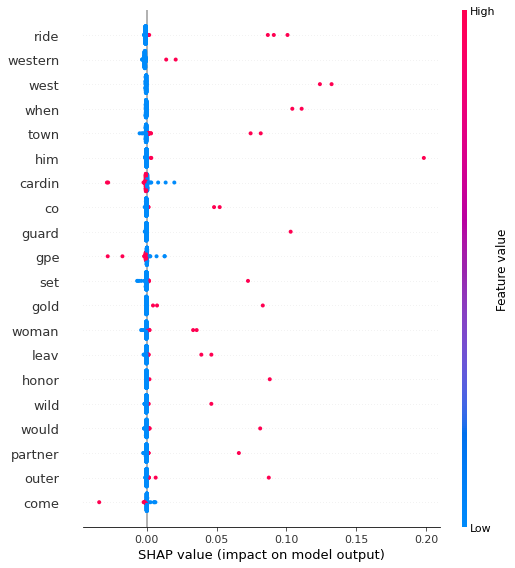

fresh


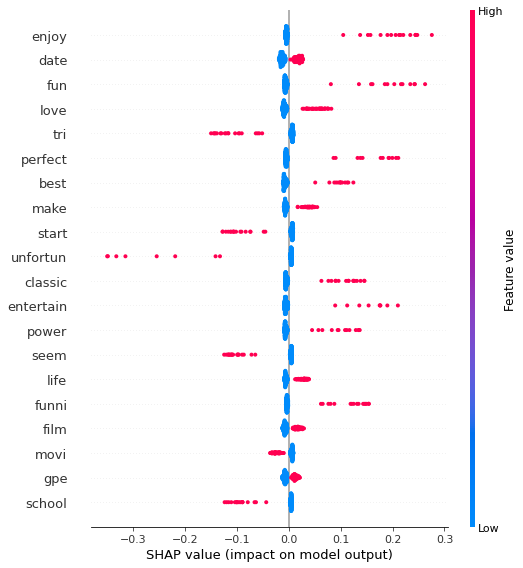

rotten


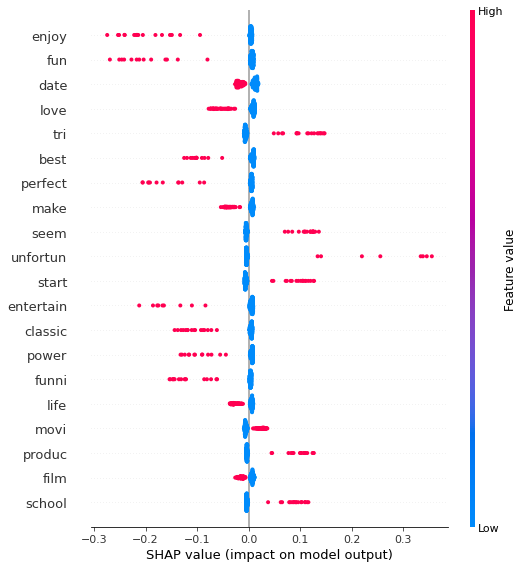

In [209]:
#code to recreate the train and test data that was used
#to calculate baseline model shap values
vocab_size=2000
text_train, text_test, y_train, y_test = read_data()
num_tags = y_test.shape[1]

print("[INFO] Processing Text...\n")
processor = TextPreprocessor(vocab_size=vocab_size)
X_train, X_test = preprocess_text(vocab_size=vocab_size, x_train_text=text_train,
                                  x_test_text=text_test, text_processor=processor)
word_dict, word_lookup = word_lookup_creation(processor=processor)



#loading and displaying baseline model shap value calculations
#for comparison purposes
print("[INFO] Displaying Figures...")
display_shap_figures(shap_values=[x for x in baseline_model_shap_vals], x_test=X_test,
                      word_lookup_reference=word_lookup)


In [210]:
#main function to train model on specified datasets. 
#make list of features to remove from training sets and retrain
#model for performance comparison

def main(vocab_size=2000, drop_features=None):

  #read in presaved data
  text_train, text_test, y_train, y_test = read_data()
  num_tags = y_test.shape[1]
  
  #remove predefined words in drop_features from corpus.
  print("[INFO] Removing words from text...\n")
  if drop_features:
    for w in drop_features:
      new_text_train = pd.Series([" ".join(word for word in x.split() if \
                  word not in drop_features) for x in text_train.text])
  else:
    new_text_train = text_train
  
  #instantiate Tokenizer and tokenize train and test splits.
  print("[INFO] Processing Text...\n")
  processor = TextPreprocessor(vocab_size=vocab_size)
  X_train, X_test = preprocess_text(vocab_size=vocab_size, x_train_text=new_text_train,
                                    x_test_text=text_test, text_processor=processor)
  
  #create word_index reference for future figures. 
  word_dict, word_lookup = word_lookup_creation(processor=processor)

  
  #instantiate and train model on train split.
  print("[INFO] Creating and Training Model...\n")
  model = create_model(input_shape=vocab_size, num_tags=num_tags)
  
  trained_model = train_and_score(model, train_data_X=X_train, train_data_y=y_train, 
                                  test_data_X=X_test, test_data_y=y_test,
                                  n_epochs=10, batch_size=128)
  
  #make predictions for confusion matrix and classification report
  y_pred = trained_model.predict(X_test)
  
  print("[INFO] Displaying Confusion Matrix ...\n")
  cm = skm.multilabel_confusion_matrix(y_test.values, y_pred.round(0))
  #reformat confusion matrix as pandas DataFrame for prettier formatting
  cm_df = pd.DataFrame(cm.reshape(cm.shape[0], -1), columns=['TN', 'FP', 'FN', 'TP'], 
                        index=y_test.columns)
  print(cm_df, "\n")

  #print classfication report
  print("[INFO] Displaying Classification Report...\n")
  print(skm.classification_report(y_test.values, y_pred.round(0), target_names=cm_df.index))

  #calculate shap values; n_examples=500 and n_explantions=50 
  #for relatively easy and quick computation
  print("[INFO] Calculating Shap Values...\n")
  if drop_features:      
    shap_vals = shap_vals_calculation(n_examples=500, n_explanations=50, 
                                      x_train=X_train, x_test=X_test, 
                                      model=trained_model)

  #display shap figures, using word_index reference created earlier.   
  print("[INFO] Displaying Figures...")
  display_shap_figures(shap_values=shap_vals, x_test=X_test,
                      word_lookup_reference=word_lookup)
    
  


In [194]:
#@title
#run for model performance metrics 
#shap values figures are above
main(vocab_size=2000)

[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 2s 68us/sample - loss: 0.2732 - acc: 0.8731 - val_loss: 0.1059 - val_acc: 0.9584
Epoch 2/10
35103/35103 [==============================] - 2s 43us/sample - loss: 0.0809 - acc: 0.9685 - val_loss: 0.0656 - val_acc: 0.9739
Epoch 3/10
35103/35103 [==============================] - 2s 43us/sample - loss: 0.0581 - acc: 0.9762 - val_loss: 0.0565 - val_acc: 0.9760
Epoch 4/10
35103/35103 [==============================] - 1s 43us/sample - loss: 0.0505 - acc: 0.9787 - val_loss: 0.0526 - val_acc: 0.9773
Epoch 5/10
35103/35103 [==============================] - 2s 45us/sample - loss: 0.0465 - acc: 0.9800 - val_loss: 0.0508 - val_acc: 0.9779
Epoch 6/10
35103/35103 [==============================] - 2s 43us/sample - loss: 0.0439 - acc: 0.9809 - val_loss: 0.0496 - val_acc: 0.9779
Epoch 7/10
3510

## Test 1:
### Remove top 5 features from global importances:
- comedi
- date
- love
- norp
- thriller

 
### Results: No discernable drop in performance in terms of classifying genres. However, some change in performance of predicting rotten or fresh.

Percent Change:
- Fresh: 
    - Precision: 0.81=>0.79
    - Recall: 0.84=>0.86
    - F1 Score: 0.82=>0.82
- Rotten:
    - Precision: 0.74=>0.74
    - Recall: 0.68=>0.65
    - F1 Score: 0.71=>0.69

Seems that the model is predicting more fresh verdicts or predicting less rotten verdicts in general, which is might be a change in performance or might just be due to randomness.

[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 2s 62us/sample - loss: 0.2327 - acc: 0.9088 - val_loss: 0.1078 - val_acc: 0.9596
Epoch 2/10
35103/35103 [==============================] - 2s 45us/sample - loss: 0.0851 - acc: 0.9665 - val_loss: 0.0683 - val_acc: 0.9728
Epoch 3/10
35103/35103 [==============================] - 2s 44us/sample - loss: 0.0612 - acc: 0.9751 - val_loss: 0.0579 - val_acc: 0.9755
Epoch 4/10
35103/35103 [==============================] - 2s 43us/sample - loss: 0.0523 - acc: 0.9779 - val_loss: 0.0534 - val_acc: 0.9770
Epoch 5/10
35103/35103 [==============================] - 2s 47us/sample - loss: 0.0478 - acc: 0.9795 - val_loss: 0.0512 - val_acc: 0.9777
Epoch 6/10
35103/35103 [==============================] - 2s 46us/sample - loss: 0.0450 - acc: 0.9804 - val_loss: 0.0494 - val_acc: 0.9782
Epoch 7/10
3510

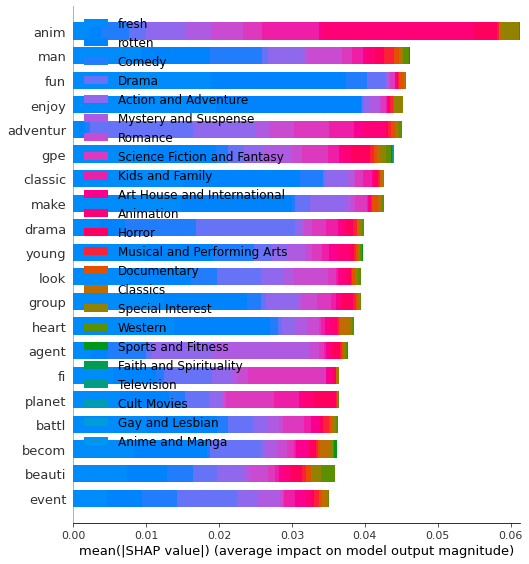

Action and Adventure


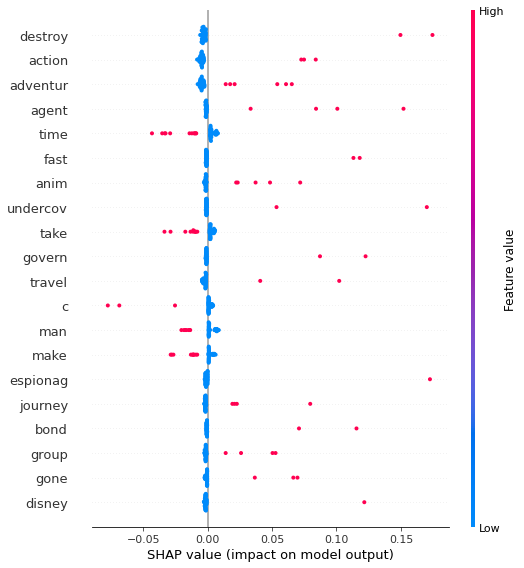

Animation


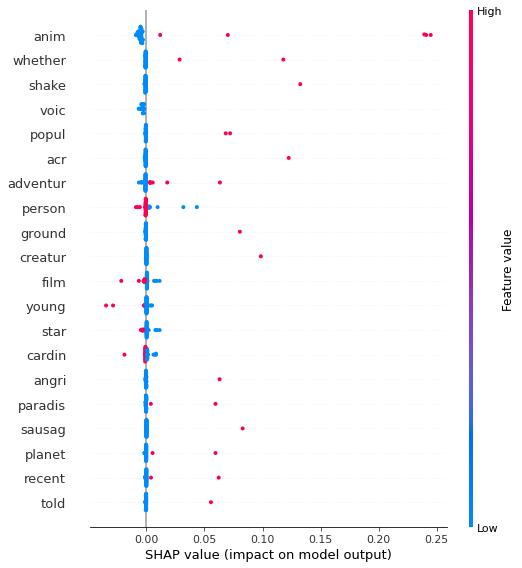

Anime and Manga


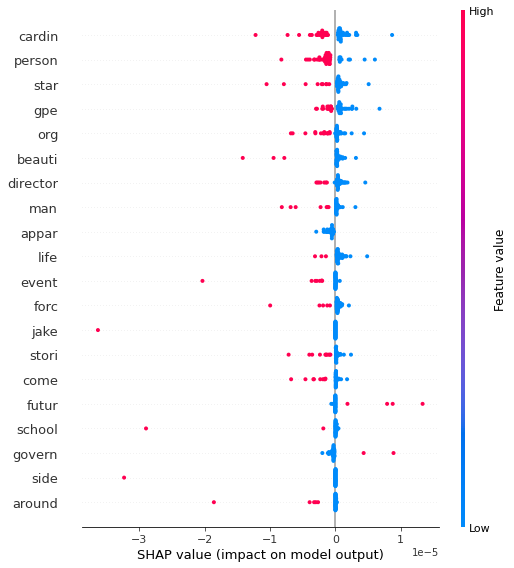

Art House and International


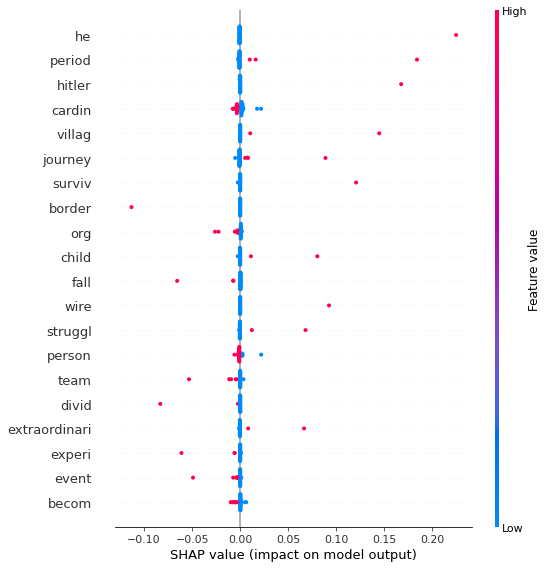

Classics


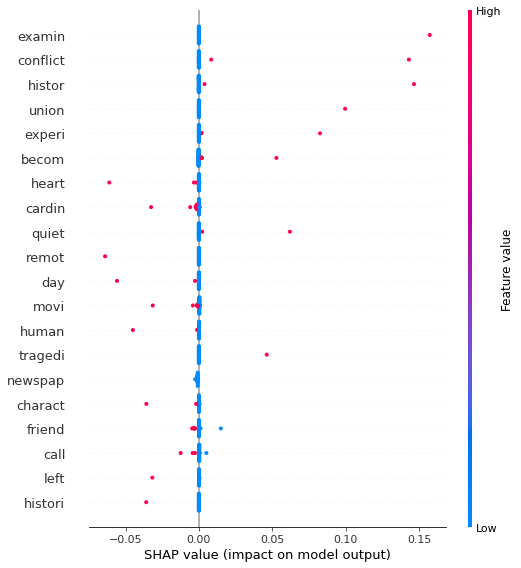

Comedy


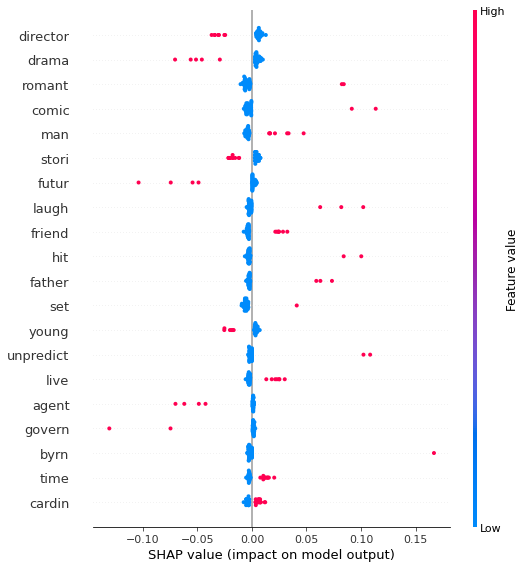

Cult Movies


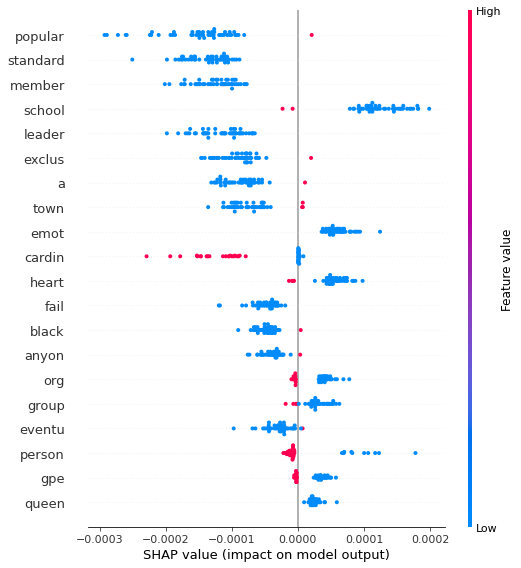

Documentary


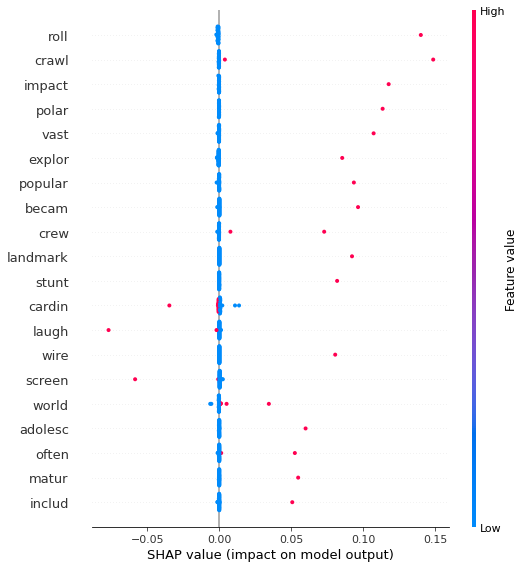

Drama


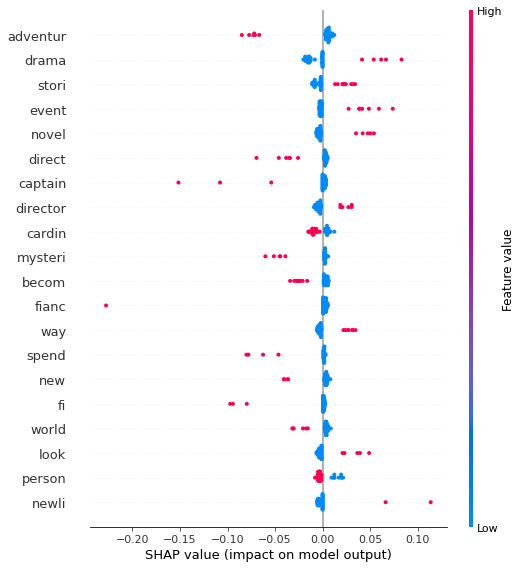

Faith and Spirituality


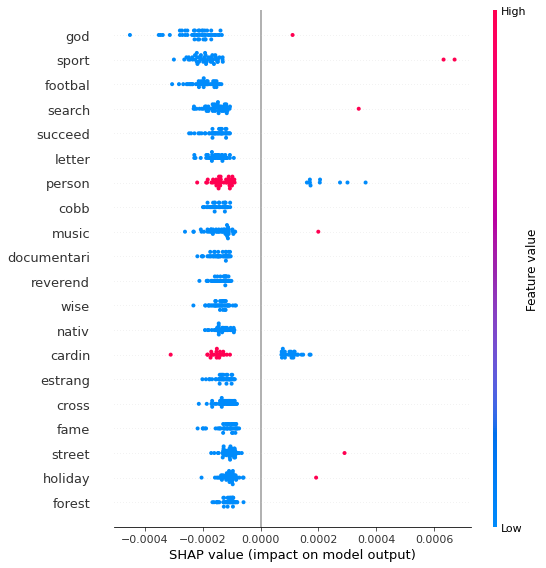

Gay and Lesbian


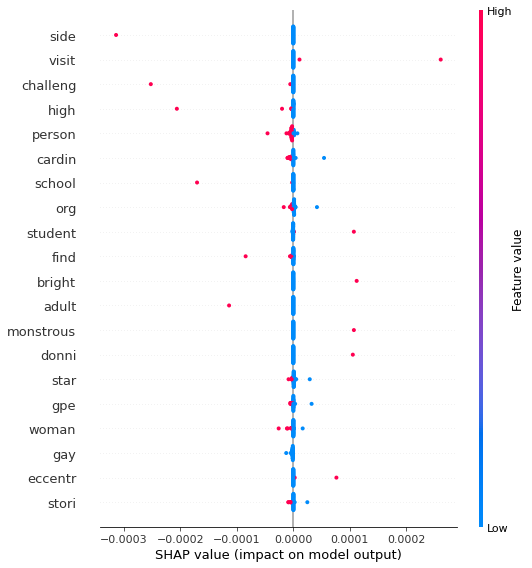

Horror


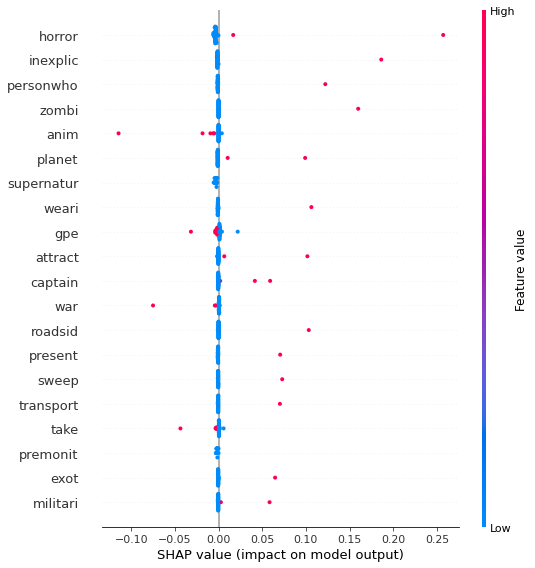

Kids and Family


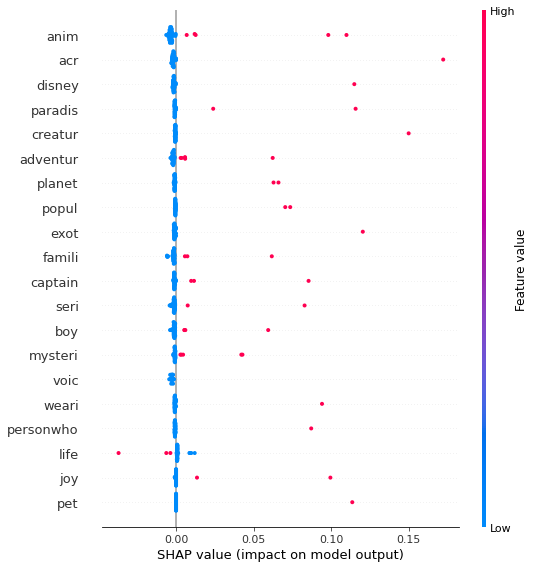

Musical and Performing Arts


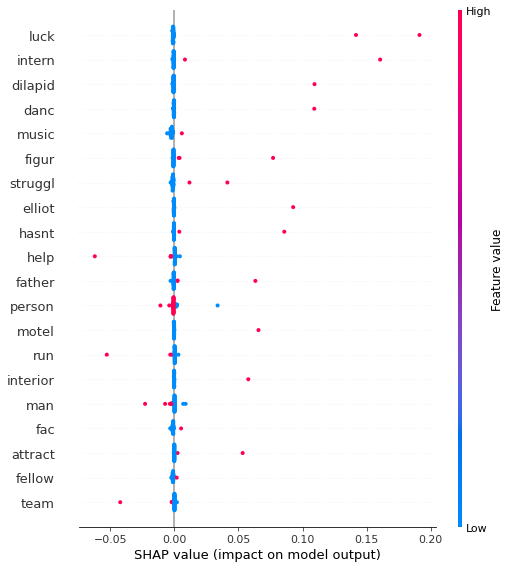

Mystery and Suspense


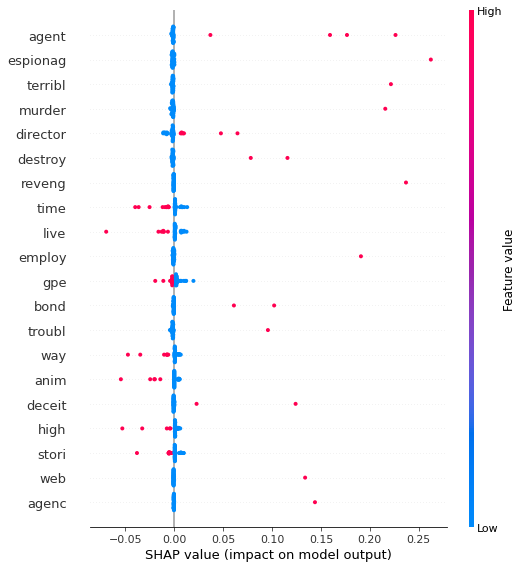

Romance


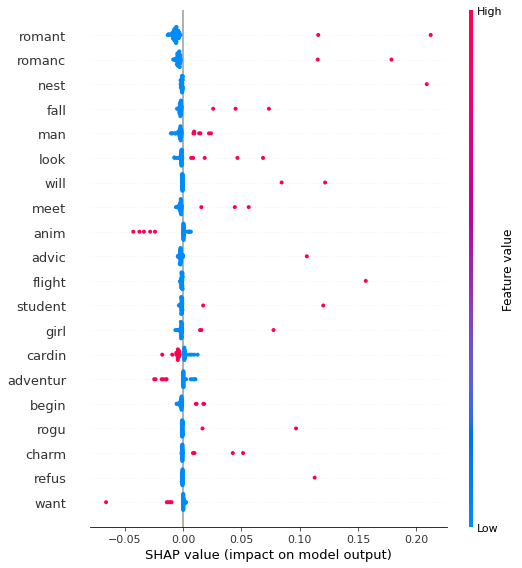

Science Fiction and Fantasy


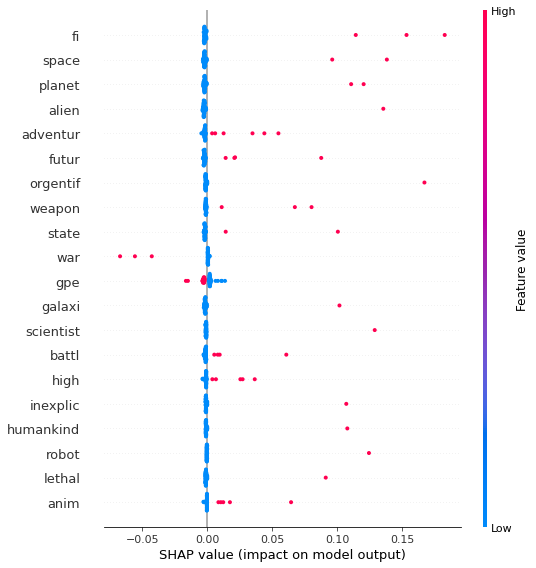

Special Interest


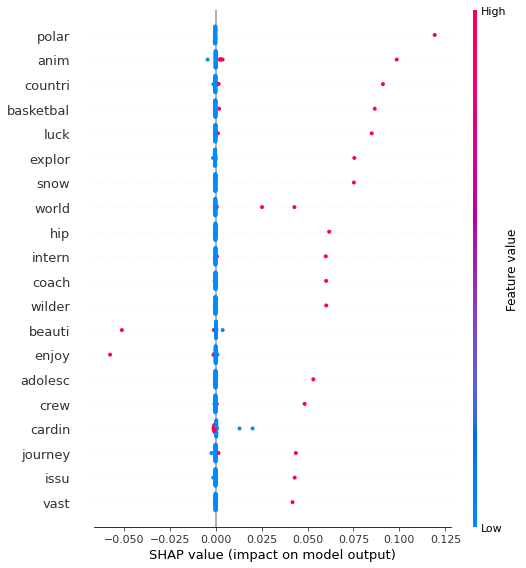

Sports and Fitness


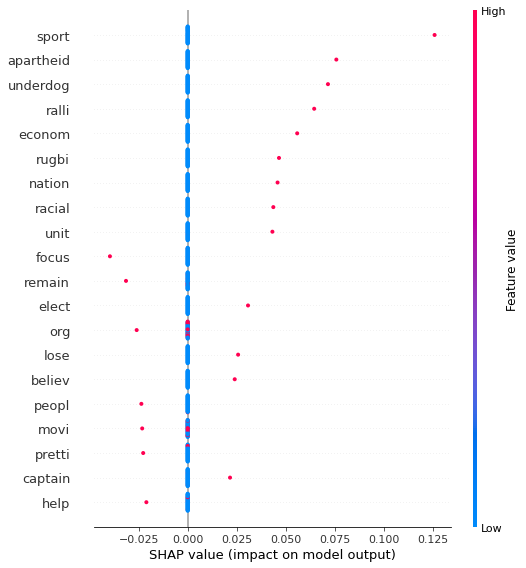

Television


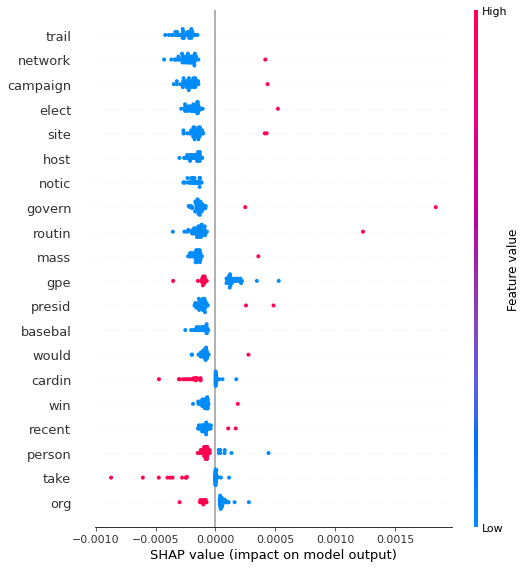

Western


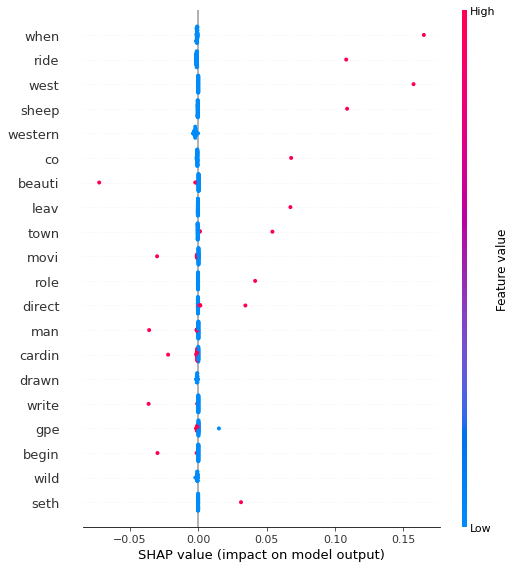

fresh


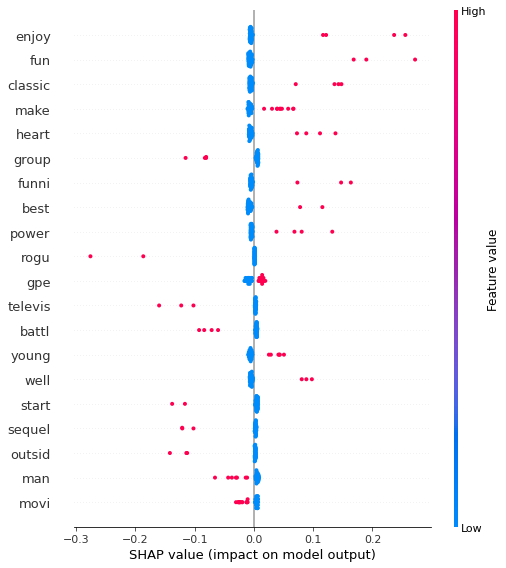

rotten


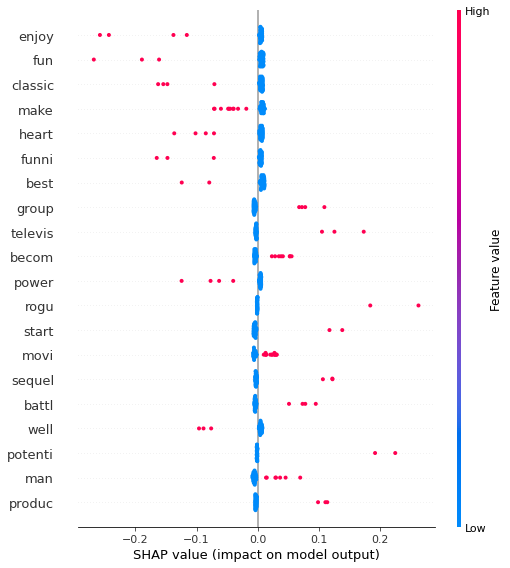

In [185]:
#@title
#TEST 1: 
main(drop_features=['comedi', 'date', 'love', 'norp', 'thriller'])

## Test 2: Drop 20 most important words
- comedi
- date
- love
- norp
- thriller
- gpe
- life
- adventur
- anim
- seri
- drama
- man
- make
- fun
- beauti
- director
- enjoy
- young
- tri
- come

### Results: Again, no discernable change in performance. Only slight (~.01-.03) change in precision/recall/f1 scores for rotten/fresh prediction scores. The new features (21st most important and lower) shap values appearing in shap global summary plot are becoming very low, almost not really informative.

[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 3s 73us/sample - loss: 0.2356 - acc: 0.9039 - val_loss: 0.0999 - val_acc: 0.9627
Epoch 2/10
35103/35103 [==============================] - 2s 47us/sample - loss: 0.0812 - acc: 0.9685 - val_loss: 0.0682 - val_acc: 0.9730
Epoch 3/10
35103/35103 [==============================] - 2s 49us/sample - loss: 0.0612 - acc: 0.9752 - val_loss: 0.0592 - val_acc: 0.9753
Epoch 4/10
35103/35103 [==============================] - 2s 50us/sample - loss: 0.0533 - acc: 0.9777 - val_loss: 0.0548 - val_acc: 0.9766
Epoch 5/10
35103/35103 [==============================] - 2s 48us/sample - loss: 0.0491 - acc: 0.9790 - val_loss: 0.0529 - val_acc: 0.9769
Epoch 6/10
35103/35103 [==============================] - 2s 49us/sample - loss: 0.0462 - acc: 0.9800 - val_loss: 0.0515 - val_acc: 0.9772
Epoch 7/10
3510

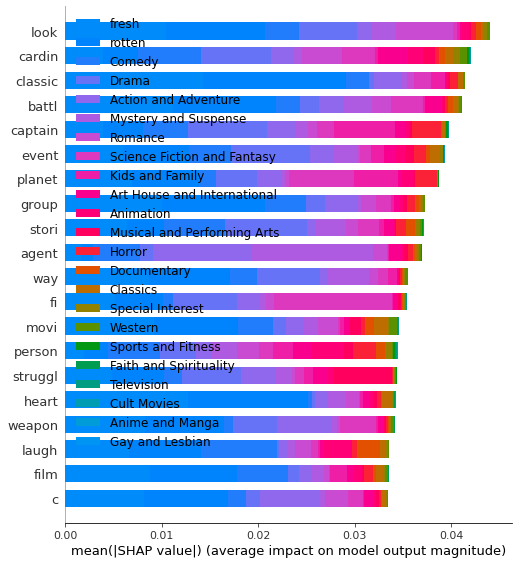

Action and Adventure


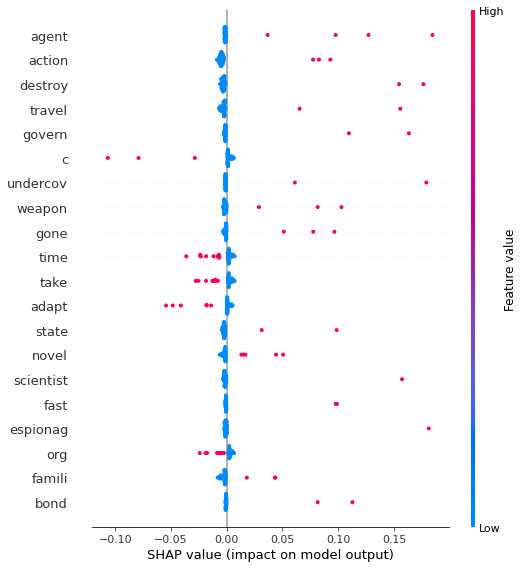

Animation


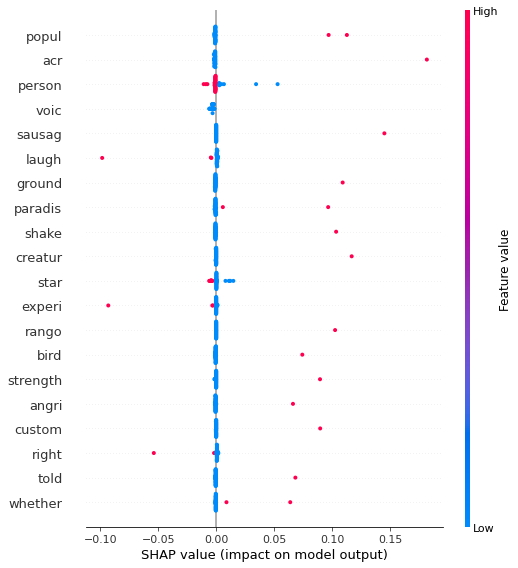

Anime and Manga


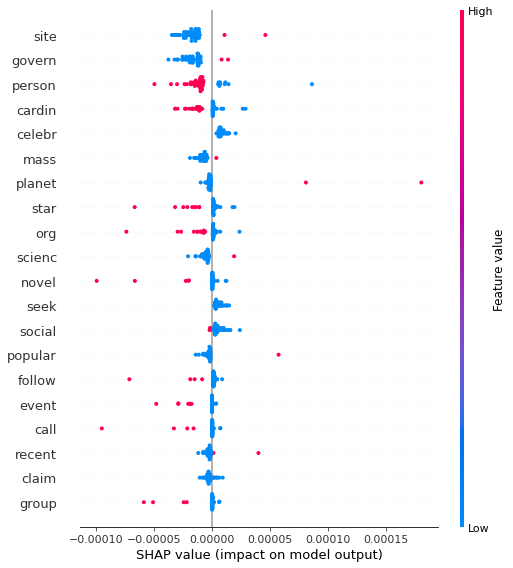

Art House and International


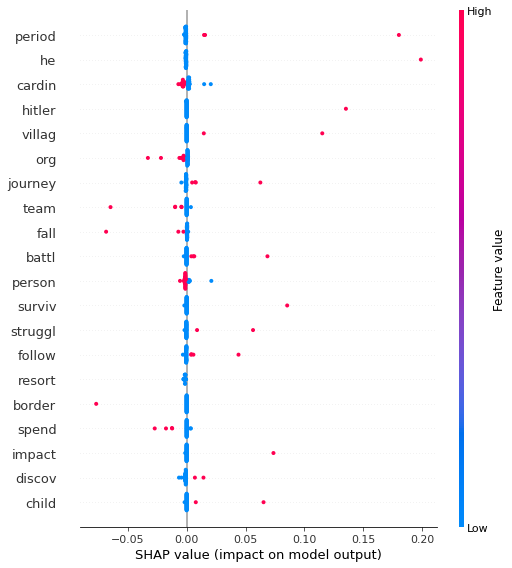

Classics


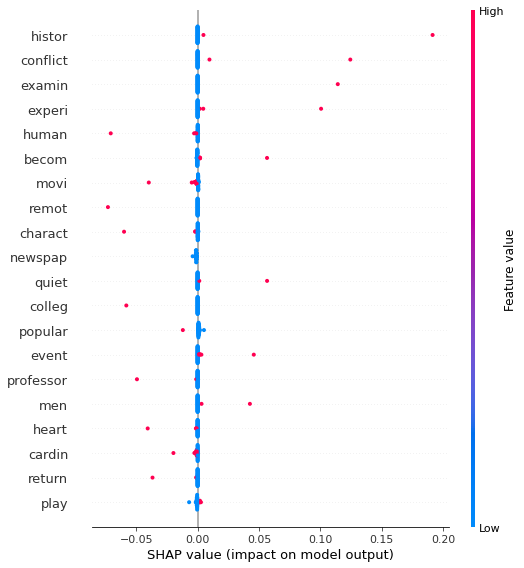

Comedy


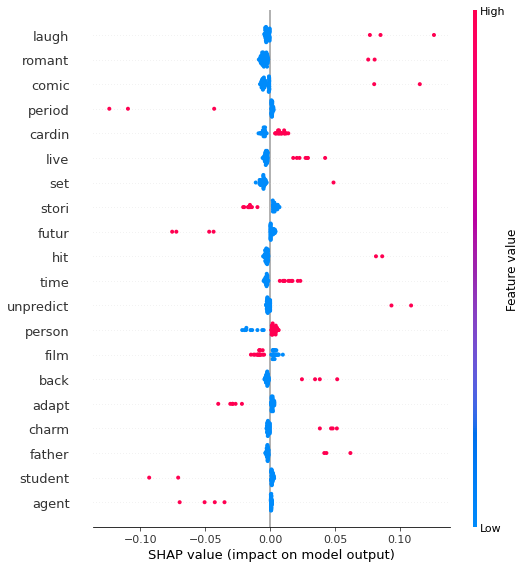

Cult Movies


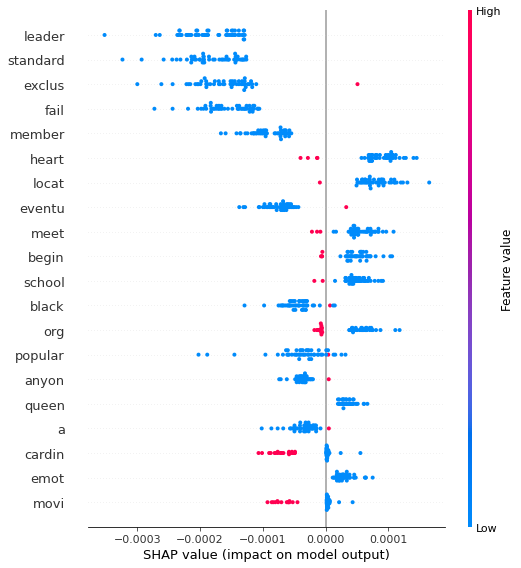

Documentary


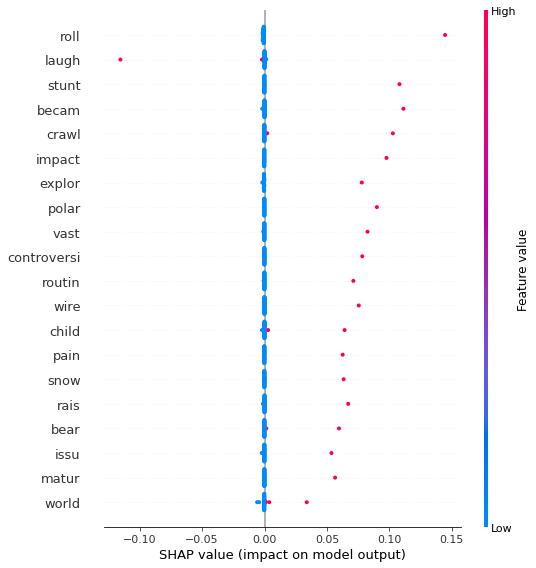

Drama


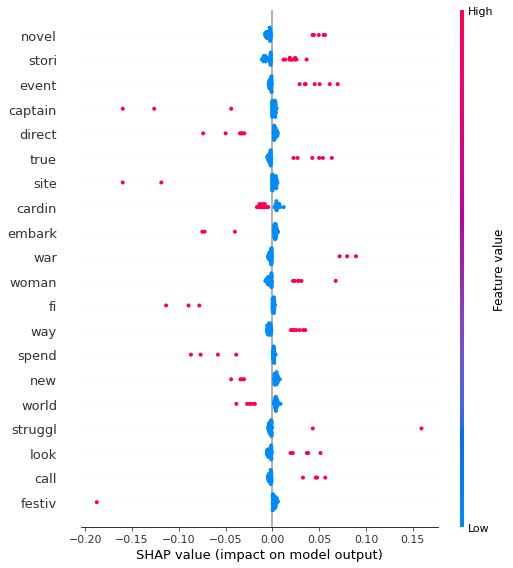

Faith and Spirituality


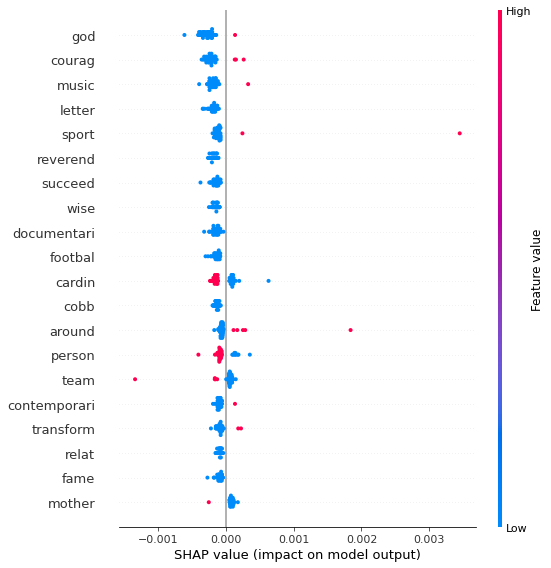

Gay and Lesbian


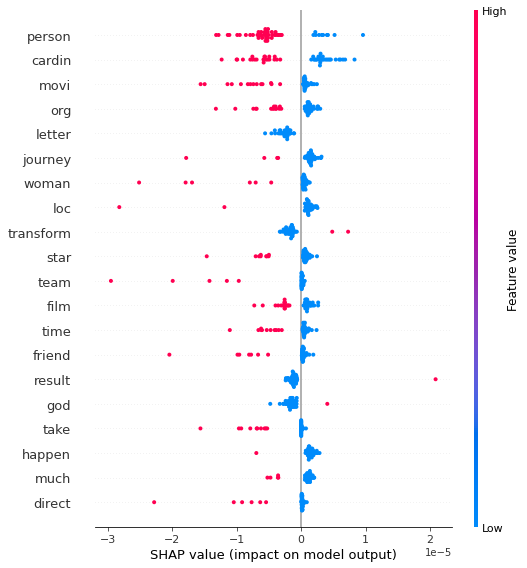

Horror


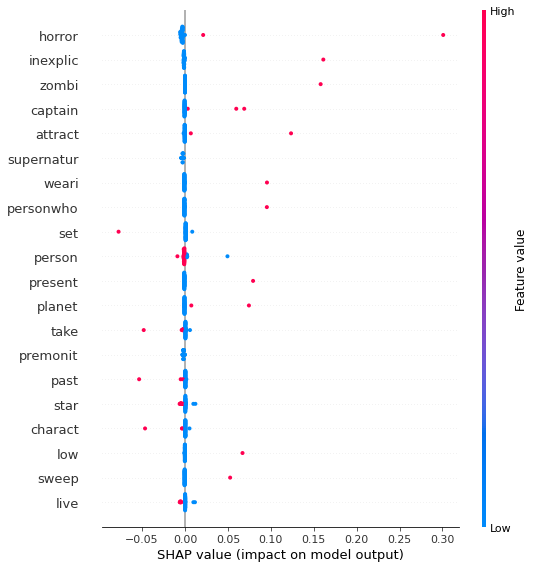

Kids and Family


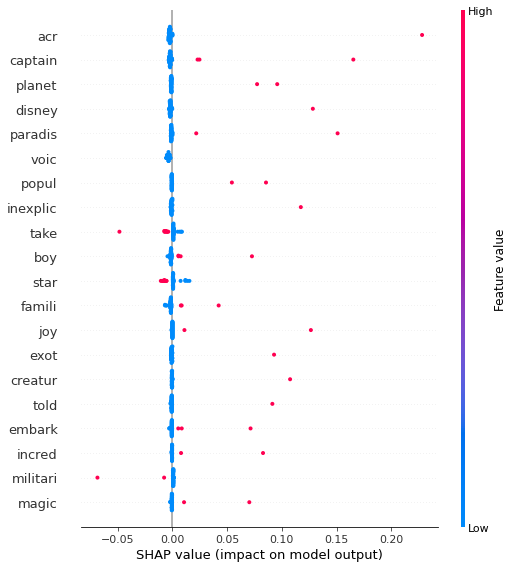

Musical and Performing Arts


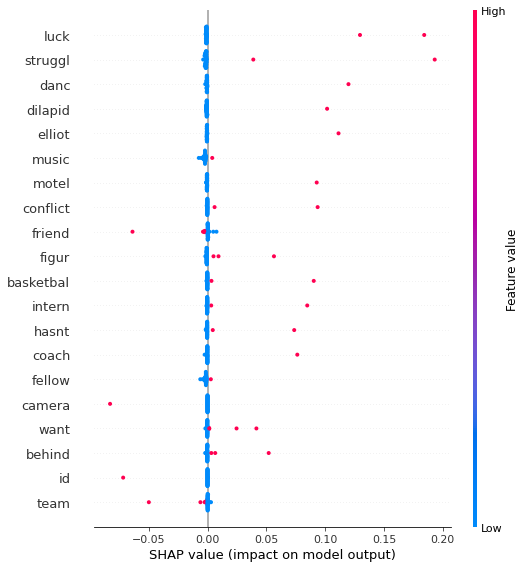

Mystery and Suspense


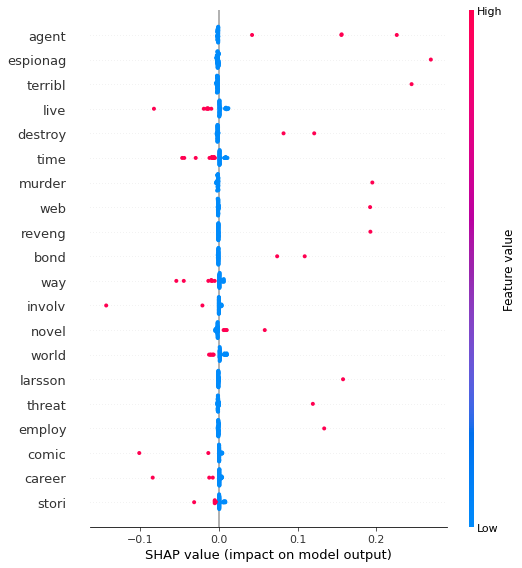

Romance


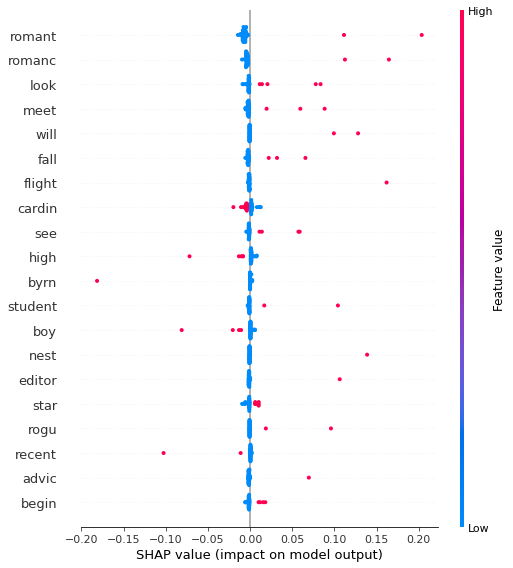

Science Fiction and Fantasy


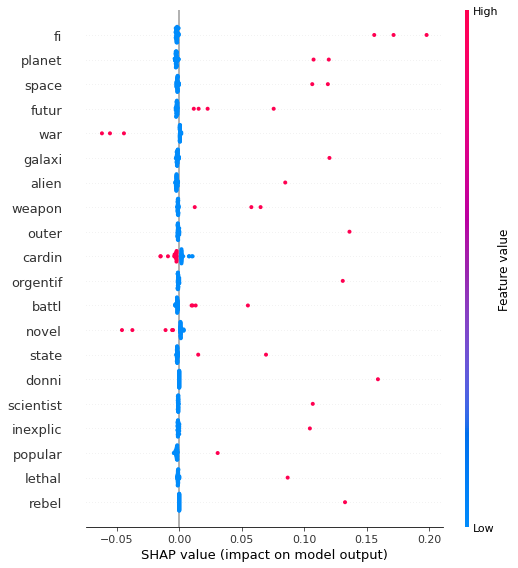

Special Interest


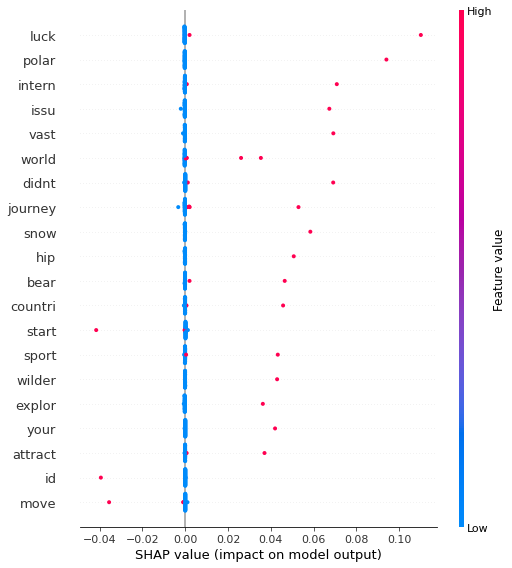

Sports and Fitness


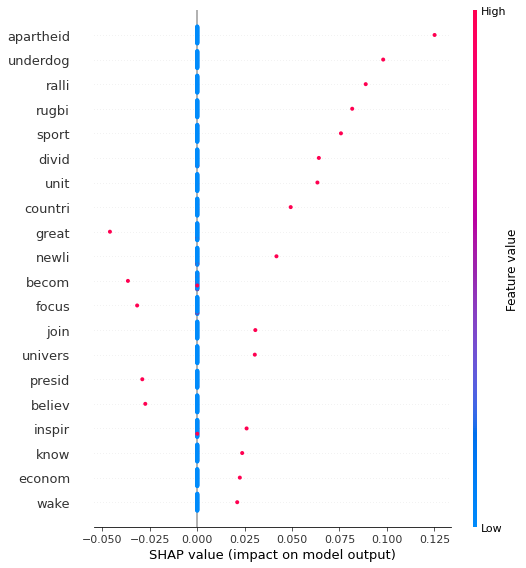

Television


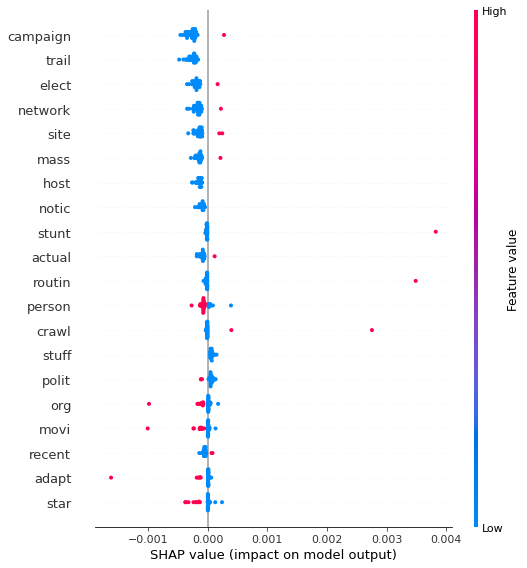

Western


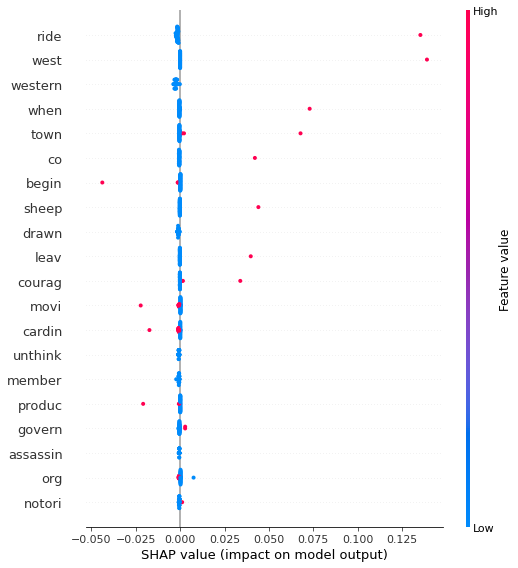

fresh


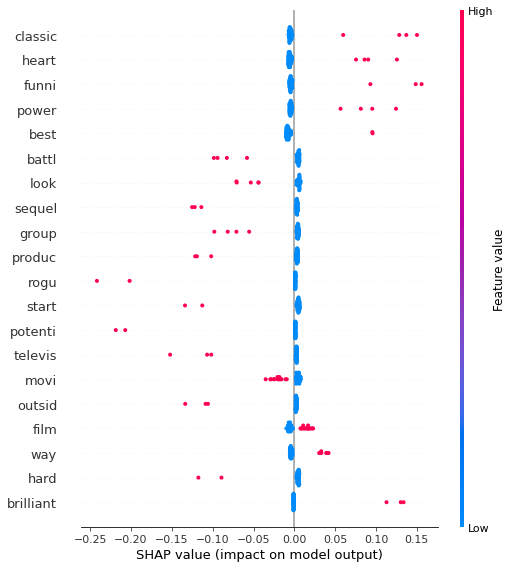

rotten


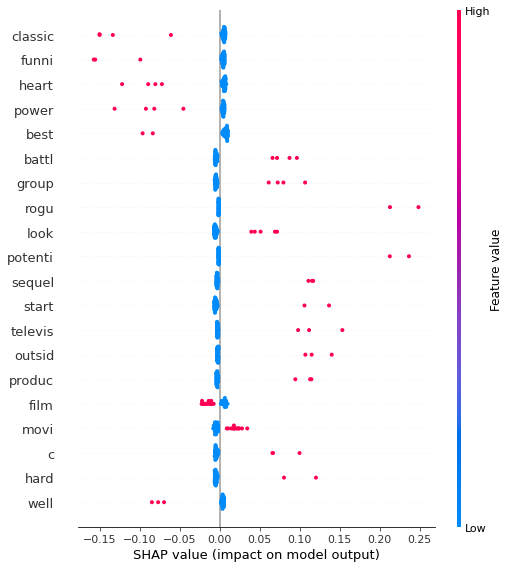

In [195]:
#@title
main(drop_features=['comedi', 'date', 'love', 'norp', 'thriller',
                    'gpe', 'life', 'adventur', 'anim', 'seri',
                    'drama', 'man', 'make', 'fun', 'beauti', 
                    'director', 'enjoy', 'young', 'tri', 'come'])

## Test 3: Remove important words for particular genre of film.

Remove 20 most important shap-derived features in "Comedy" genre and see if model has change in performance in classifiying the genre. 

Results: No change in performance; metrics are virtually identical.

[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 3s 80us/sample - loss: 0.2509 - acc: 0.8974 - val_loss: 0.1058 - val_acc: 0.9616
Epoch 2/10
35103/35103 [==============================] - 2s 50us/sample - loss: 0.0826 - acc: 0.9683 - val_loss: 0.0679 - val_acc: 0.9731
Epoch 3/10
35103/35103 [==============================] - 2s 51us/sample - loss: 0.0601 - acc: 0.9758 - val_loss: 0.0584 - val_acc: 0.9754
Epoch 4/10
35103/35103 [==============================] - 2s 51us/sample - loss: 0.0517 - acc: 0.9787 - val_loss: 0.0536 - val_acc: 0.9771
Epoch 5/10
35103/35103 [==============================] - 2s 49us/sample - loss: 0.0468 - acc: 0.9802 - val_loss: 0.0521 - val_acc: 0.9776
Epoch 6/10
35103/35103 [==============================] - 2s 51us/sample - loss: 0.0441 - acc: 0.9811 - val_loss: 0.0498 - val_acc: 0.9780
Epoch 7/10
3510

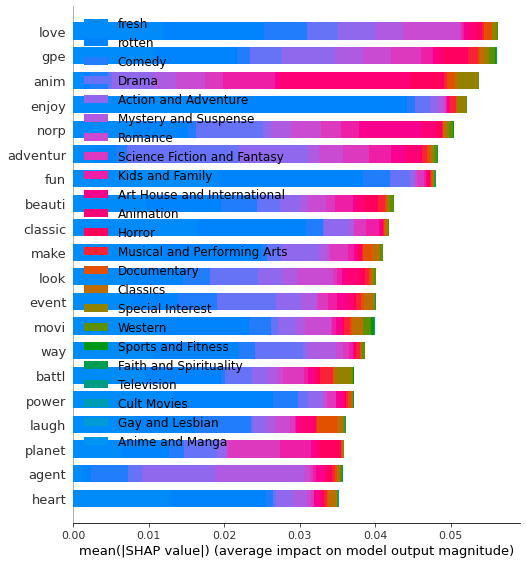

Action and Adventure


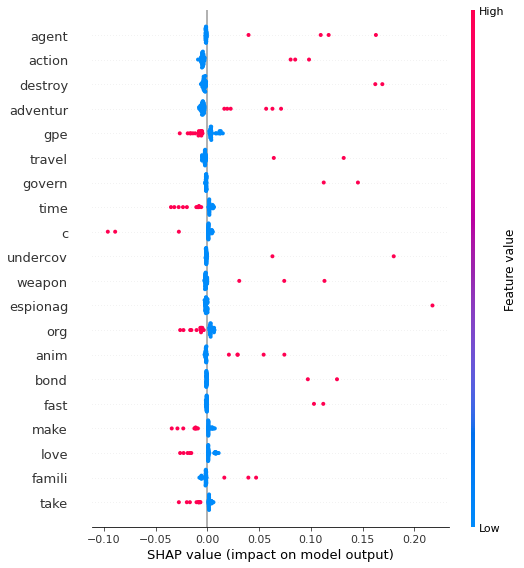

Animation


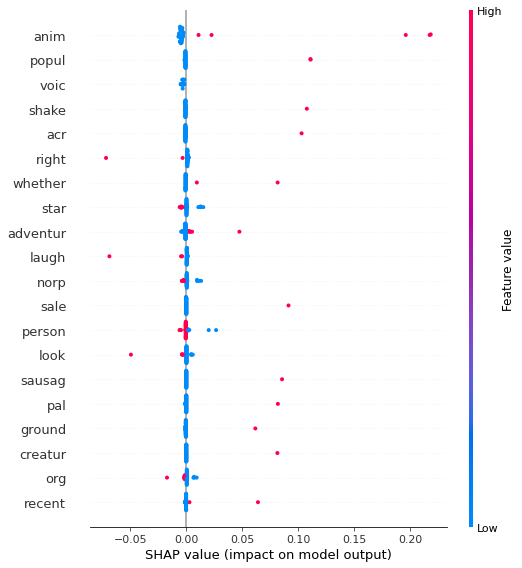

Anime and Manga


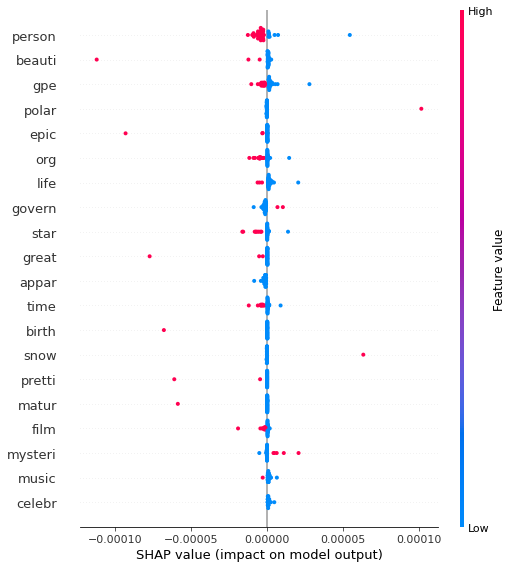

Art House and International


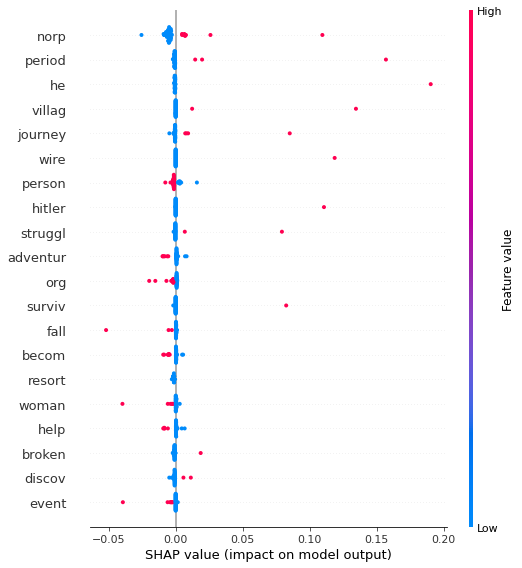

Classics


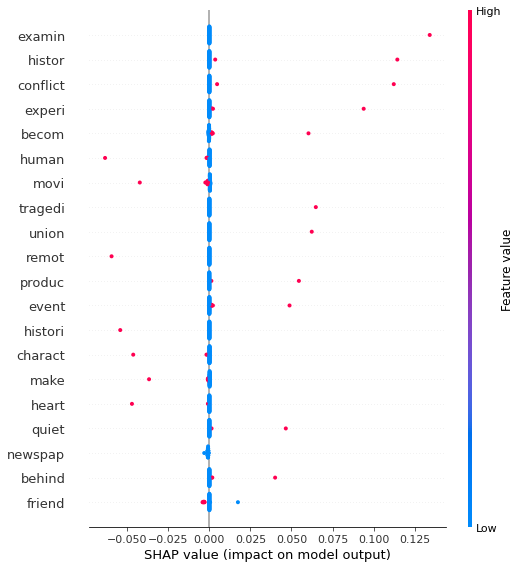

Comedy


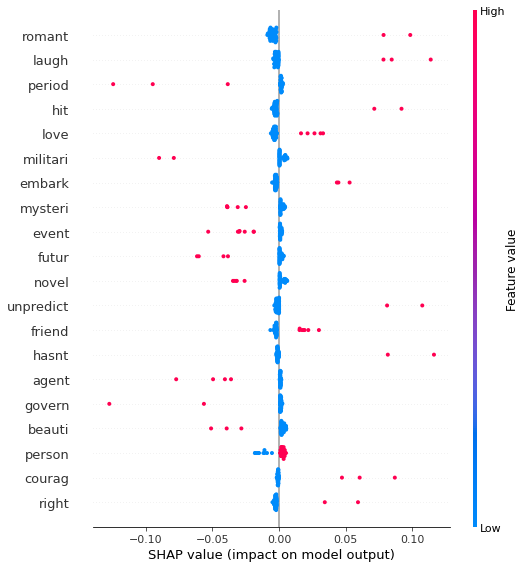

Cult Movies


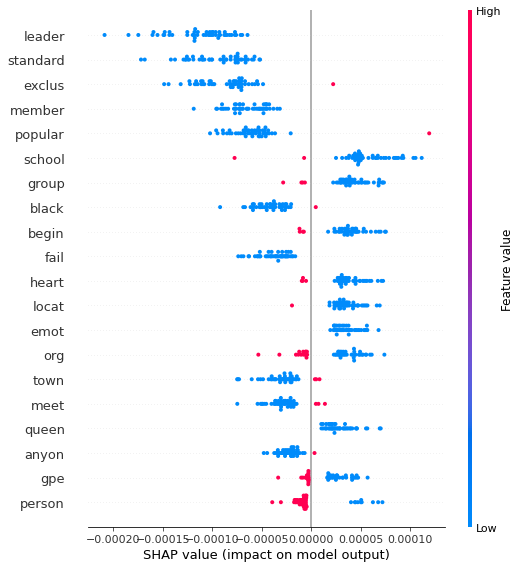

Documentary


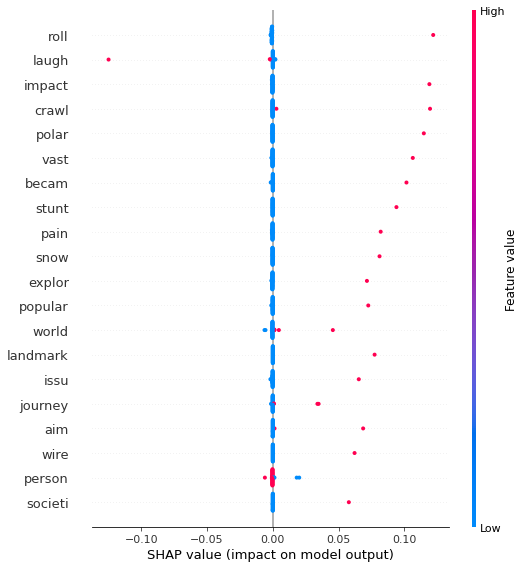

Drama


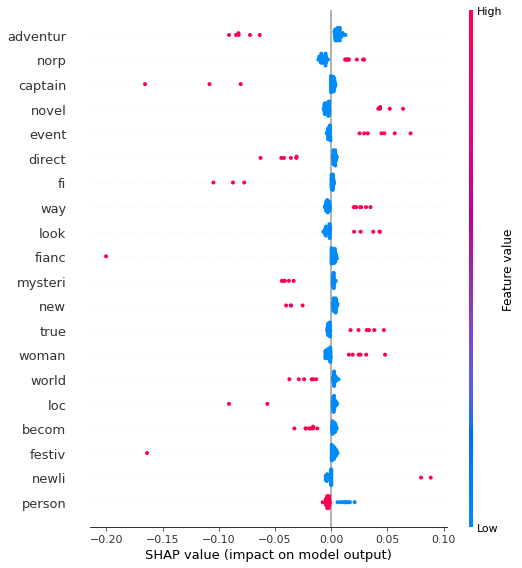

Faith and Spirituality


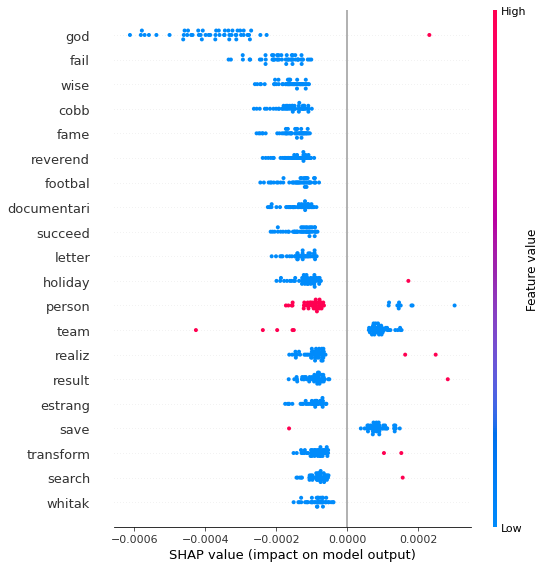

Gay and Lesbian


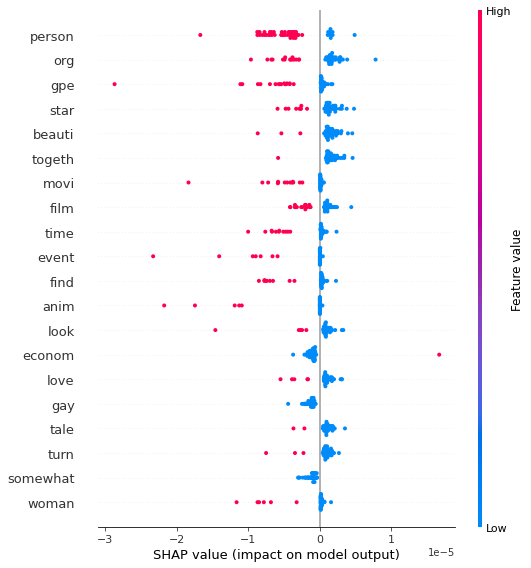

Horror


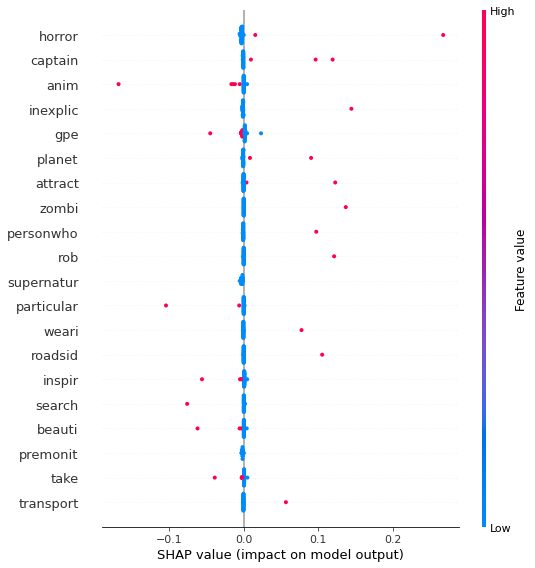

Kids and Family


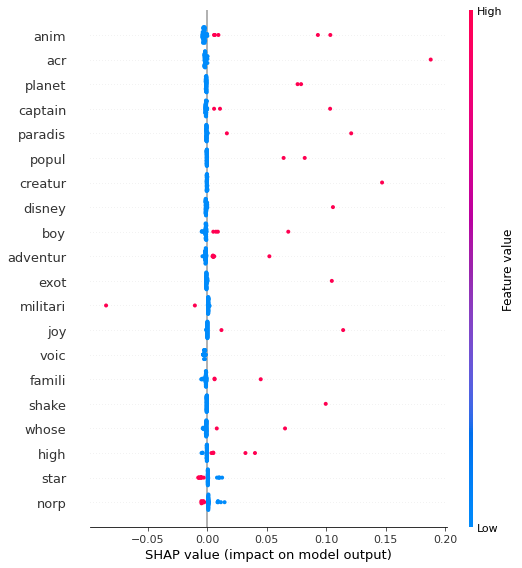

Musical and Performing Arts


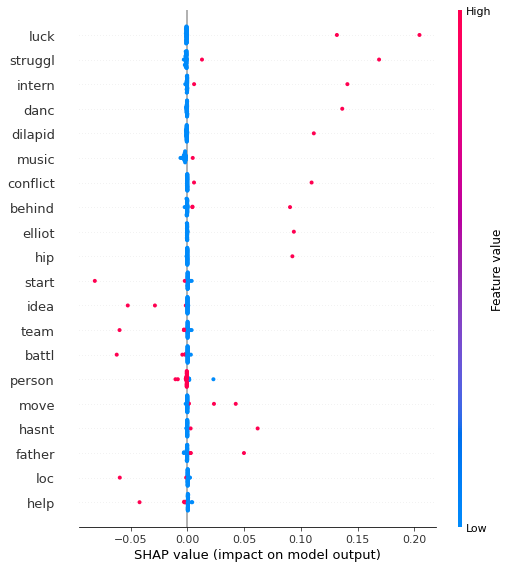

Mystery and Suspense


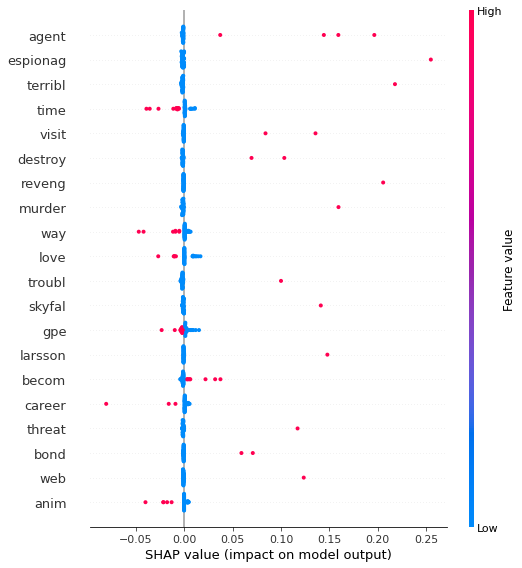

Romance


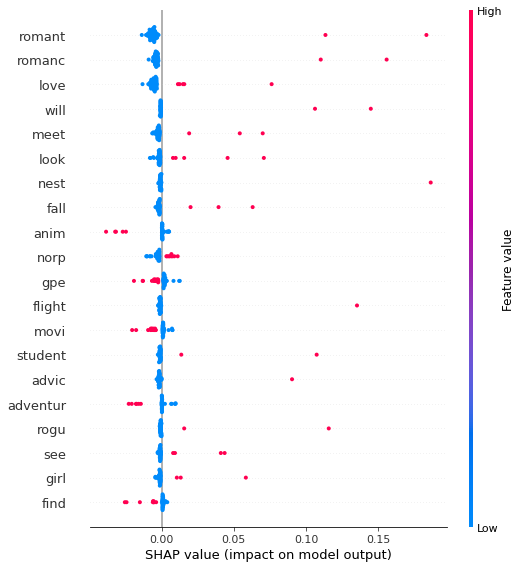

Science Fiction and Fantasy


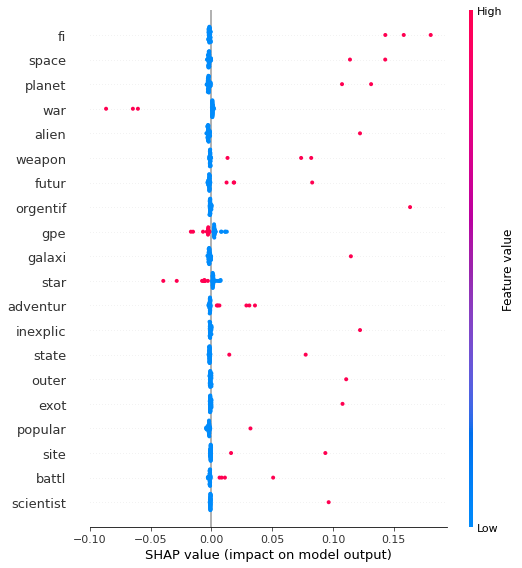

Special Interest


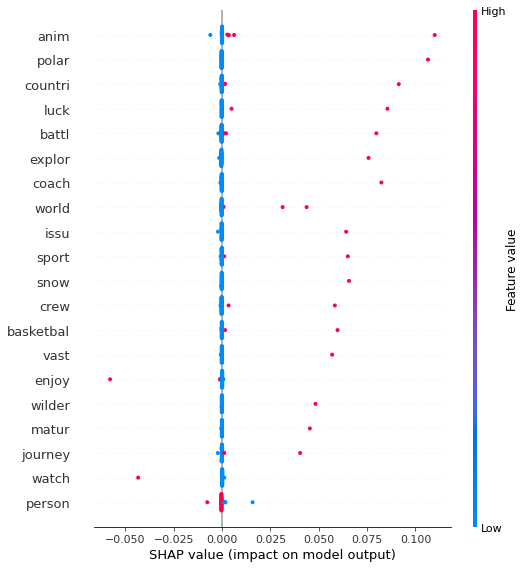

Sports and Fitness


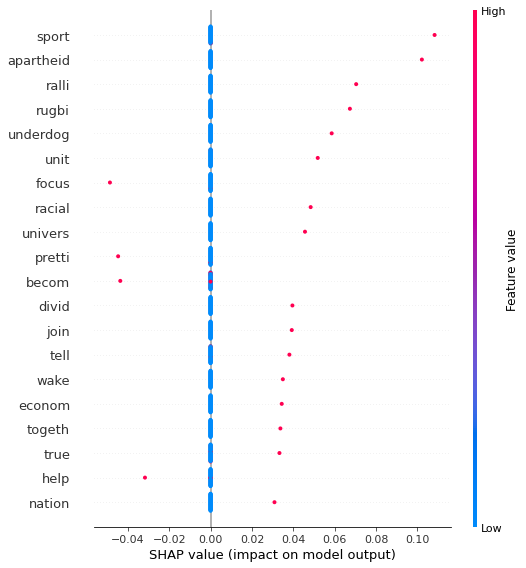

Television


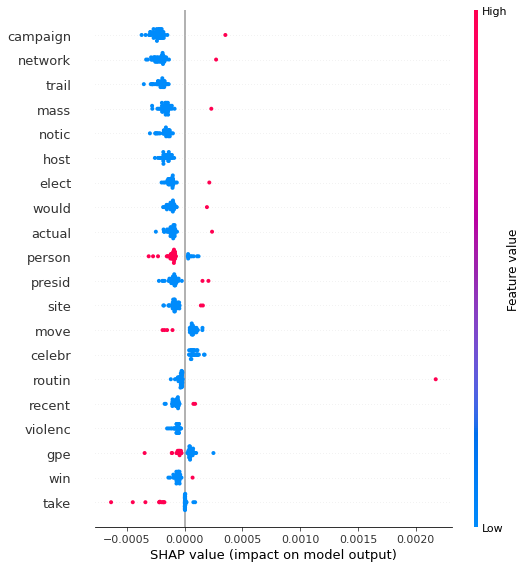

Western


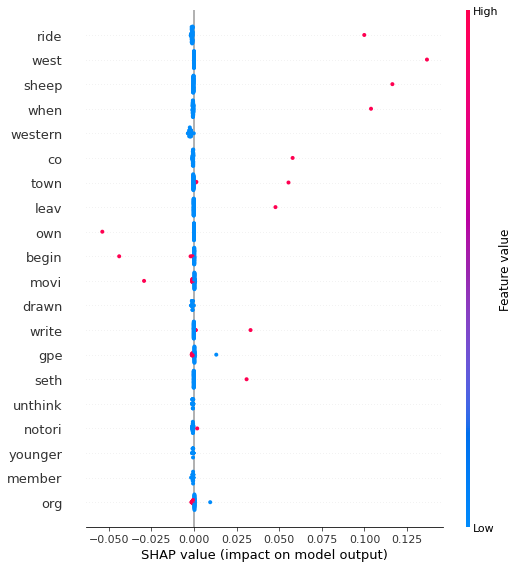

fresh


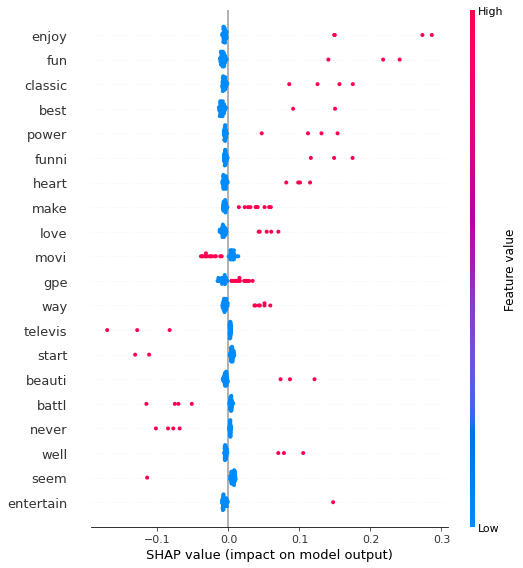

rotten


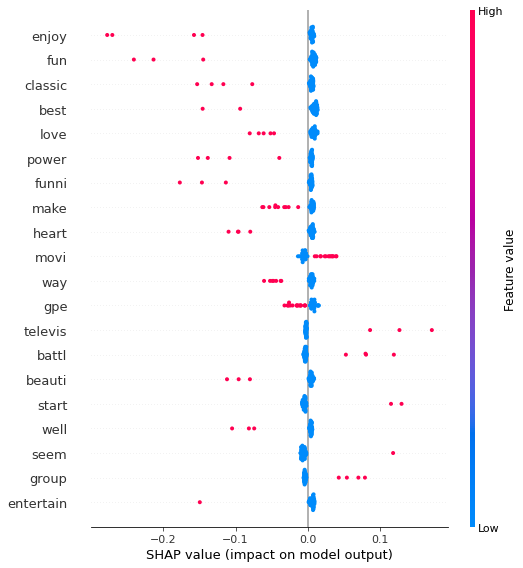

In [196]:
#@title
#Test 3: Comdedy Genre
main(drop_features=['comedi', 'drama', 'thriller', 'director', 'set',
                    'comic', 'live', 'cardin', 'adapt', 'stori', 
                    'attempt', 'man', 'wife', 'young', 'night',
                    'seri', 'colleg', 'date', 'mother', 'back'])

## Test 4: Removing top 20 words/features for Fresh/Rotten classification

Remove the top 20 words that influence the prediction of fresh.

Results: Again, not much change in performance; if anything, a slight disimprovement of "rotten" prediction performance. But again, this may be in part due to randomness. 

__Baseline__:
- fresh       
  - Precision 0.81
  - Recall 0.84
  - F1 0.82      
- rotten
  - Precision 0.74
  - Recall 0.68
  - F1 0.71

__Removed__:
- fresh       
  - Precision 0.79
  - Recall 0.86
  - F1 0.82      
- rotten
  - Precision 0.74
  - Recall 0.65
  - F1 0.69


[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 3s 84us/sample - loss: 0.2194 - acc: 0.9151 - val_loss: 0.0999 - val_acc: 0.9627
Epoch 2/10
35103/35103 [==============================] - 2s 46us/sample - loss: 0.0807 - acc: 0.9684 - val_loss: 0.0676 - val_acc: 0.9725
Epoch 3/10
35103/35103 [==============================] - 2s 46us/sample - loss: 0.0614 - acc: 0.9747 - val_loss: 0.0586 - val_acc: 0.9752
Epoch 4/10
35103/35103 [==============================] - 2s 48us/sample - loss: 0.0537 - acc: 0.9775 - val_loss: 0.0548 - val_acc: 0.9762
Epoch 5/10
35103/35103 [==============================] - 2s 46us/sample - loss: 0.0493 - acc: 0.9789 - val_loss: 0.0521 - val_acc: 0.9769
Epoch 6/10
35103/35103 [==============================] - 2s 46us/sample - loss: 0.0463 - acc: 0.9799 - val_loss: 0.0510 - val_acc: 0.9772
Epoch 7/10
3510

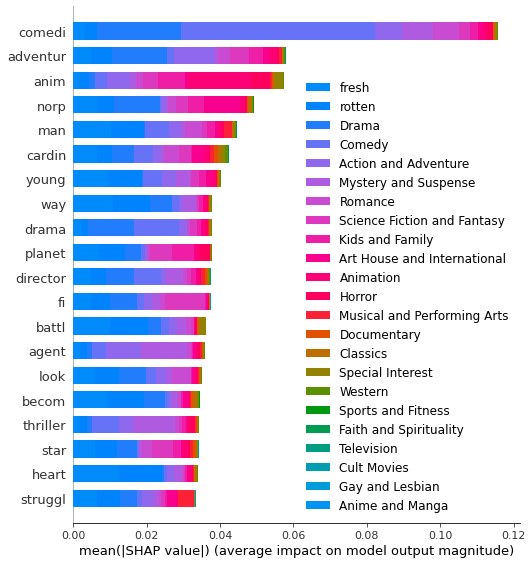

Action and Adventure


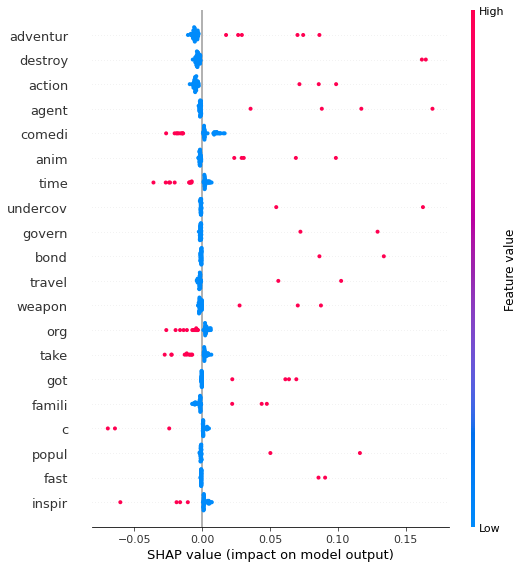

Animation


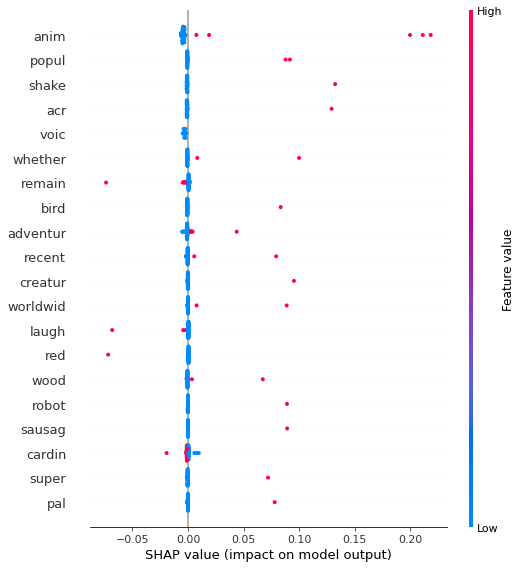

Anime and Manga


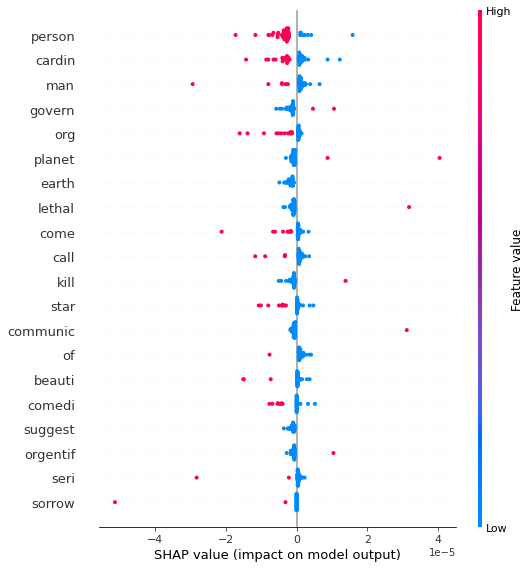

Art House and International


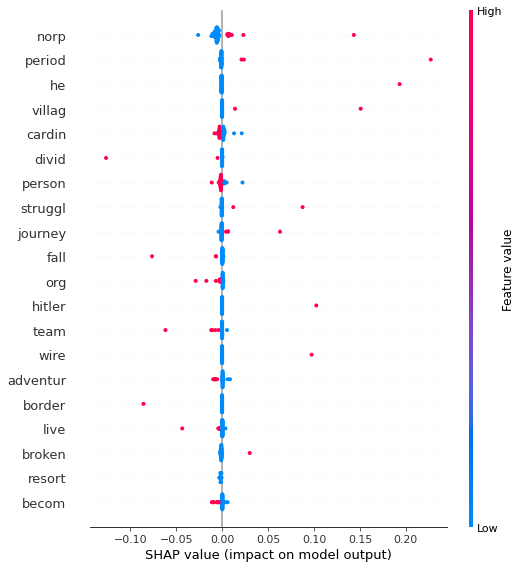

Classics


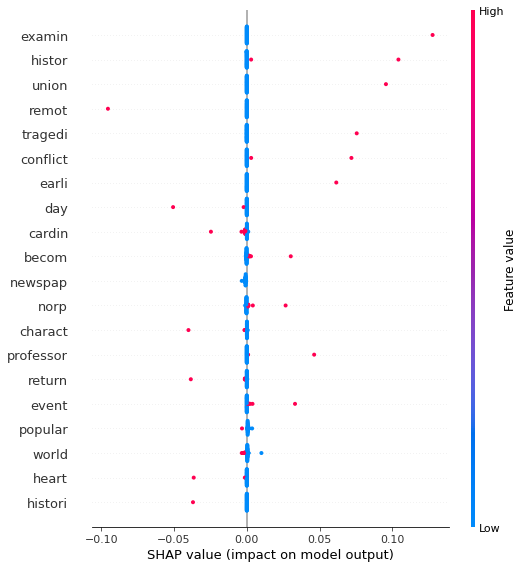

Comedy


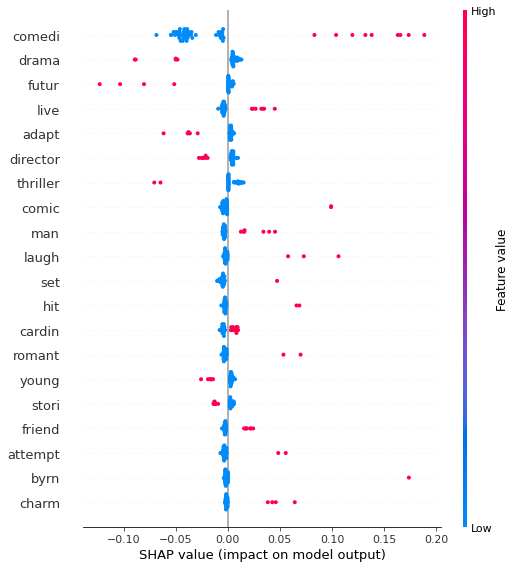

Cult Movies


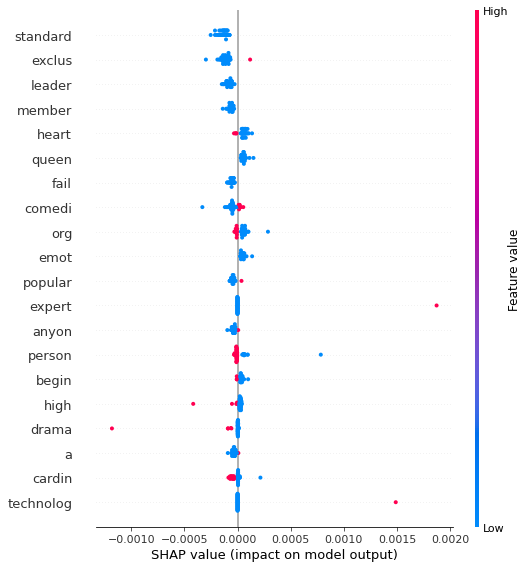

Documentary


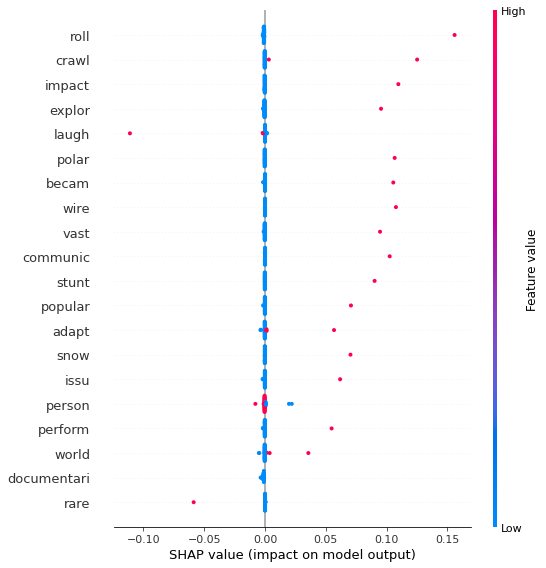

Drama


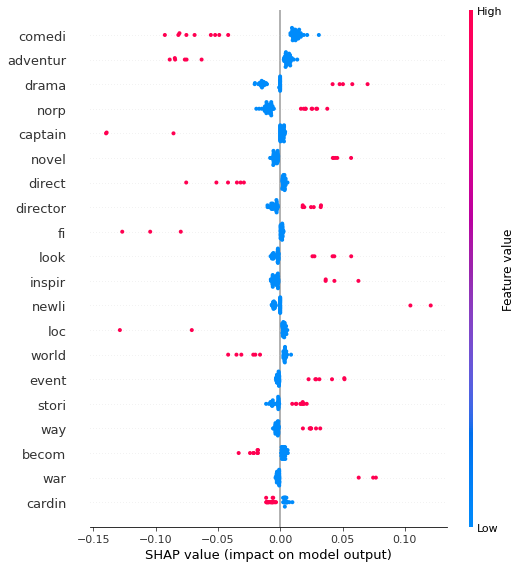

Faith and Spirituality


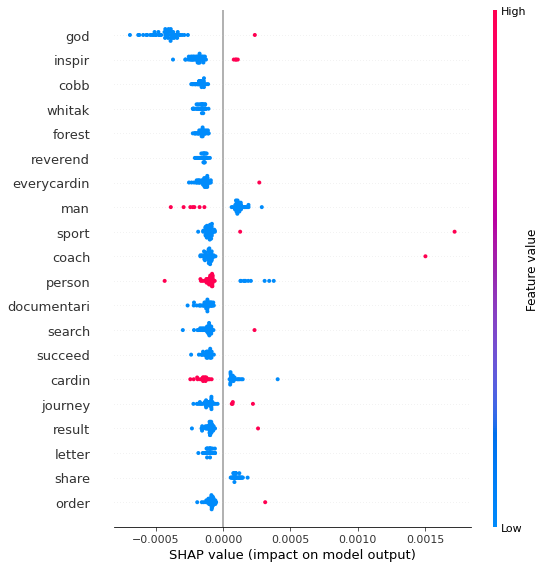

Gay and Lesbian


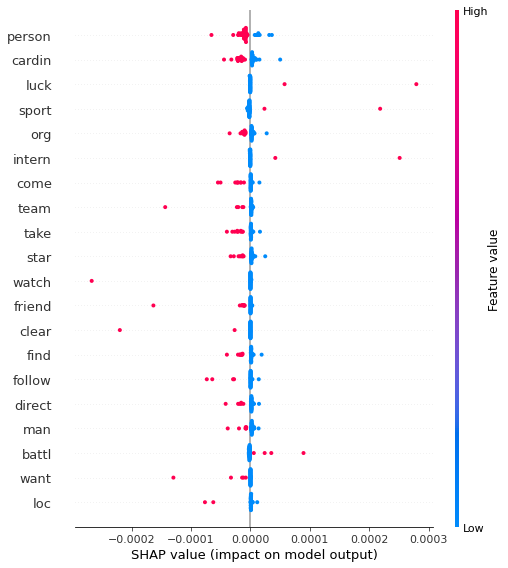

Horror


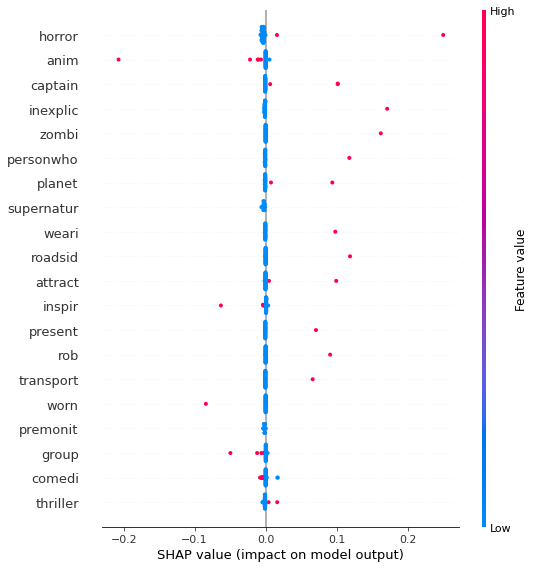

Kids and Family


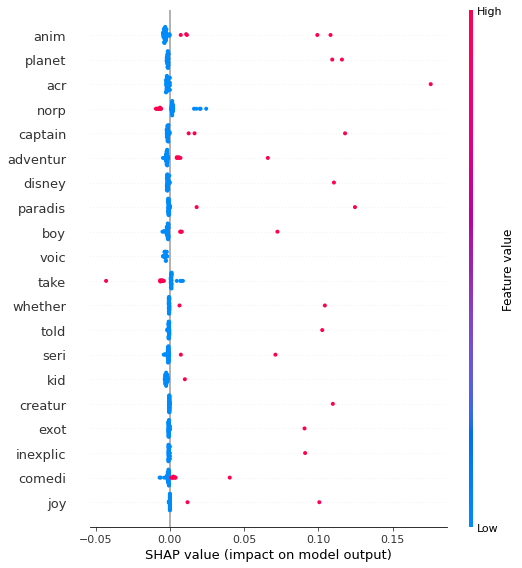

Musical and Performing Arts


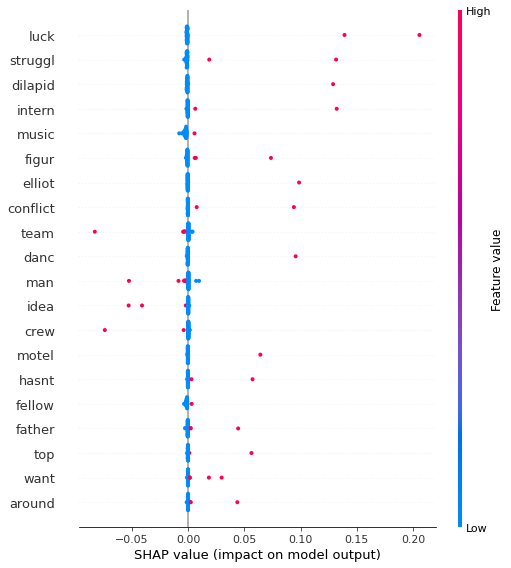

Mystery and Suspense


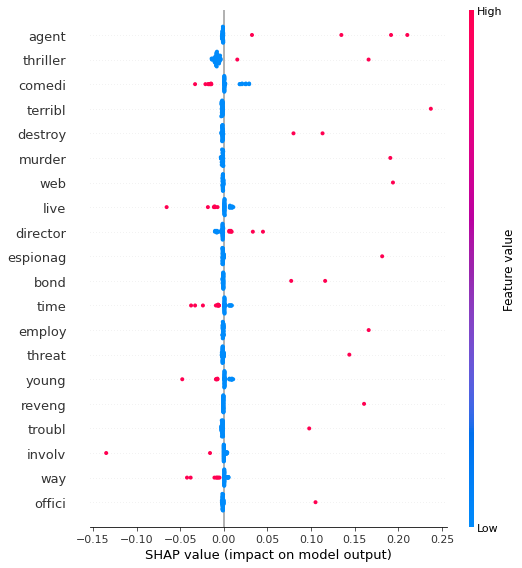

Romance


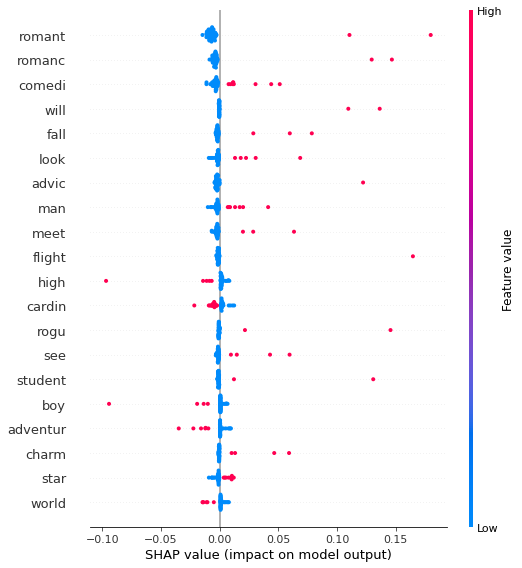

Science Fiction and Fantasy


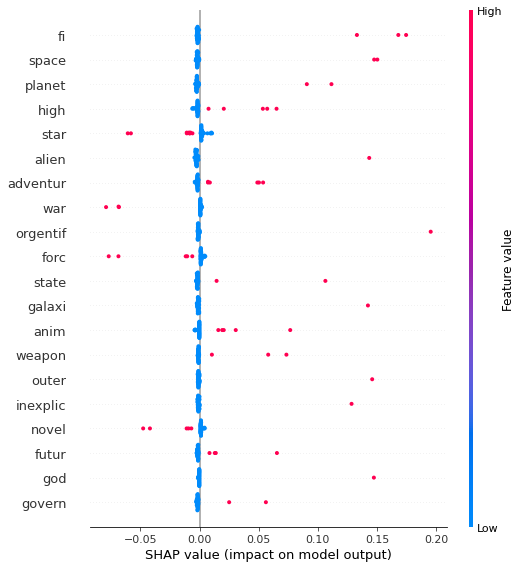

Special Interest


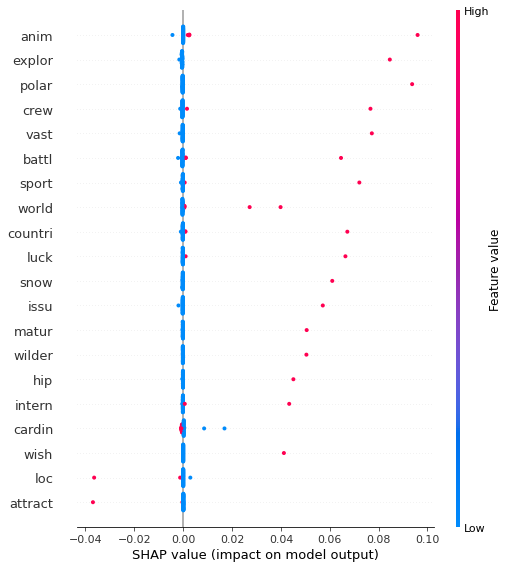

Sports and Fitness


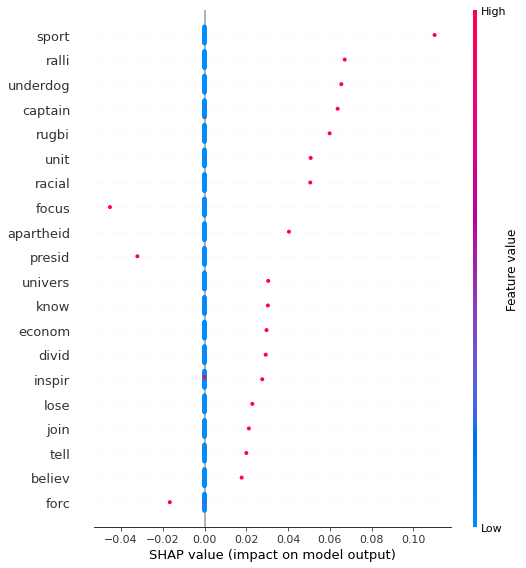

Television


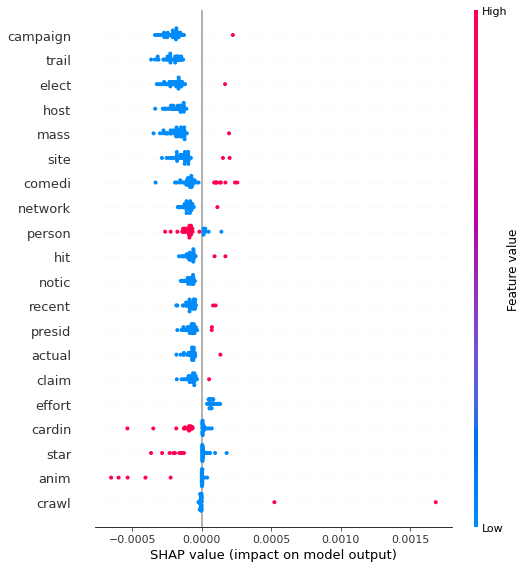

Western


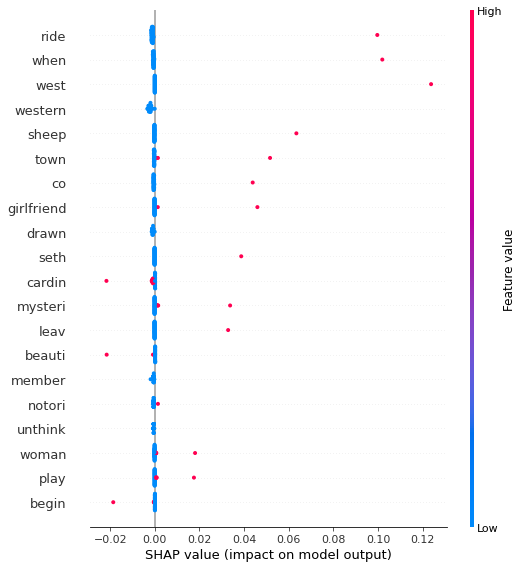

fresh


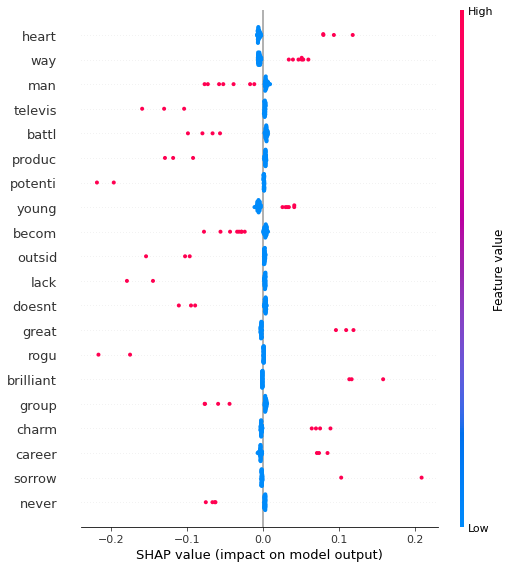

rotten


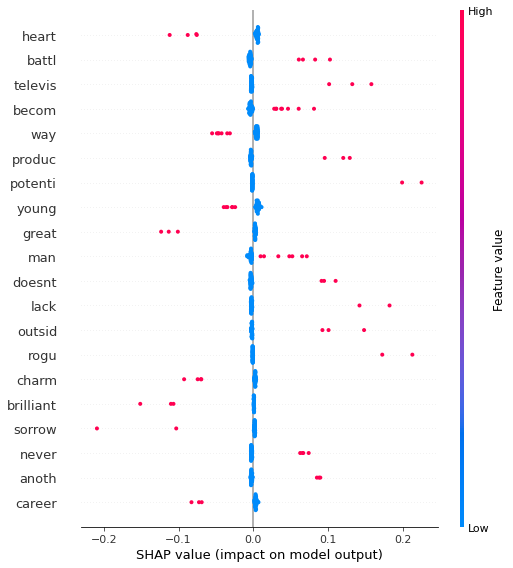

In [204]:
#@title
main(drop_features=['enjoy', 'date', 'fun', 'love', 'tri',
                    'perfect', 'best', 'make', 'start', 'unfortun',
                    'classic', 'entertain', 'power', 'seem', 'life',
                    'funni', 'film', 'movi', 'gpe', 'school'])

# Next Steps: nlp_shap_3

need to view single instances
view single instanaces for a particualr genre
view instances for collection of multi-label genres. 

In [ ]:
#need to view single instances
#view single instanaces for a particualr genre
#view instances for collection of multi-label genres. 